# <p style="font-weight:bold" > JB데이터 분석 경진대회 <br>
　JB5 (언택트금융센터 : 소윤섭 대리, 박동준 대리, 조혜지 대리) </p>

### 목차

- Chapter 0. 개요
- Chapter 1. 데이터 구조 파악(시각화)
- Chapter 2. 분석 방향 설정
- Chapter 3. 의사결정을 위한 방법론적 분석 (다양한 분석 모형 탐색)
- Chapter 4. 이항로지스틱 회귀분석을 통한 상품 추천 모형 생성
- Chapter 5. 생성된 모형에 Test 데이터 대입하여 솔루션(정답값) 도출
- Chapter 6. 결론 및 한계

## Chapter 0. 개요

<h7> - 일반적인 분석 과정에서 데이터 분석 방향을 설정하고 목적에 맞는 데이터 수집이 진행되는 것에 비해, 한정된 데이터가 주어진 상황에서 분석을 진행해야 하다 보니,<br>
　주어진 데이터 정확한 인식과 파악이 중요할 것으로 생각하였고, 데이터 구조 및 각 변수들이 갖는 의미가 무엇인인지 파악하는 데 초기 많은 시간을 할애하였음<br>
　또한 주어진 과제에 대해 정확하게 인식하고자 전체적인 데이터 구조 연결관계에 대해 고민하였음 </h7> 
    <br><br>


<h7>  - 주요 과제를 설정하고 확인하면서 데이터 구조 파악 진행<br>
* Product info Data 관련
    1. 어떤 상품들인가? <br>
    2. 상품의 종류는 몇가지이고 어떤식으로 분류되어있는가? <br>
    3. 사람들이 가장 많이 사는 상품은 어떤것인가?<br>
    4. 상품별로 add_order, week_day, order_hour, order_interval 등의 정보들이 구매 여부에 대하여 유의한 의미를 가지는가?

* Past Data 관련
    1. 각 장바구니는 어떤식으로 연관되어 있는가?
    2. Order_Id, Add_order, Cstno, order_interval, is_reorder등 각변수들의 관계가 어떤식으로 이루어져 있는가?<br>
　- 해당 고객의 Order_Id, Product_id 별로 is_reorder가 1인 경우는 -> 반드시 과거에 구매한 이력이 있는가?<br>
　- 상품의 키값으로 사용할 항목이 있는가? 없으면 어떤 항목을 키값으로 만들어서 사용해야 하는가?<br>
　- 결측값이나 null값, 공백값들은 있는가? 해당 값들의 의미는 무엇인가?<br>
    3. Past에서 구매했었던 상품정보를 Y값을 예측하기에 어떤식으로 사용할 것인가?

* Current Data 관련
    1. Current의 상품정보를 가지고 어떤 상품을 / 몇개씩 추천할 것인가?
    2. Current의 Data에는 고객별로 중복된 장바구니와 상품이 있는가?
    3. Current에서 구매된 상품(Y)은 과거에 반드시 구매했었던 상품인가?
    4. Current에서 과거에 구매한 적이 없는 고객이 있는가?
    5. Current에서 과거에 한가지 상품만 구매한 고객이 있는가?
<br>

## Chapter 1. 데이터 구조 파악(시각화)

In [126]:
## 라이브러리 import

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from jbfg.pandas_utils import *

schema = 'l2_jbbk_extnl'

In [127]:
## Table schema

sql1 = 'select * from products_info'
sql2 = 'SELECT *  FROM train_x_past '
sql3 = 'SELECT  *  FROM train_x_current '
sql4 = 'SELECT *  FROM train_y '

df_product  = get_df(sql1, schema)
df_past  = get_df(sql2, schema)
df_current  = get_df(sql3, schema)
df_y  = get_df(sql4, schema)

In [128]:
## products_info 테이블 파악_1

df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     100 non-null    object
 1   name           100 non-null    object
 2   category_id    100 non-null    object
 3   division_id    100 non-null    object
 4   category_name  100 non-null    object
 5   division_name  100 non-null    object
dtypes: object(6)
memory usage: 4.8+ KB


In [129]:
## products_info  테이블 파악_2
## 결측치(NULL) 확인

df_product.isnull().sum()

## 결측치 없음.

product_id       0
name             0
category_id      0
division_id      0
category_name    0
division_name    0
dtype: int64

<BarContainer object of 21 artists>

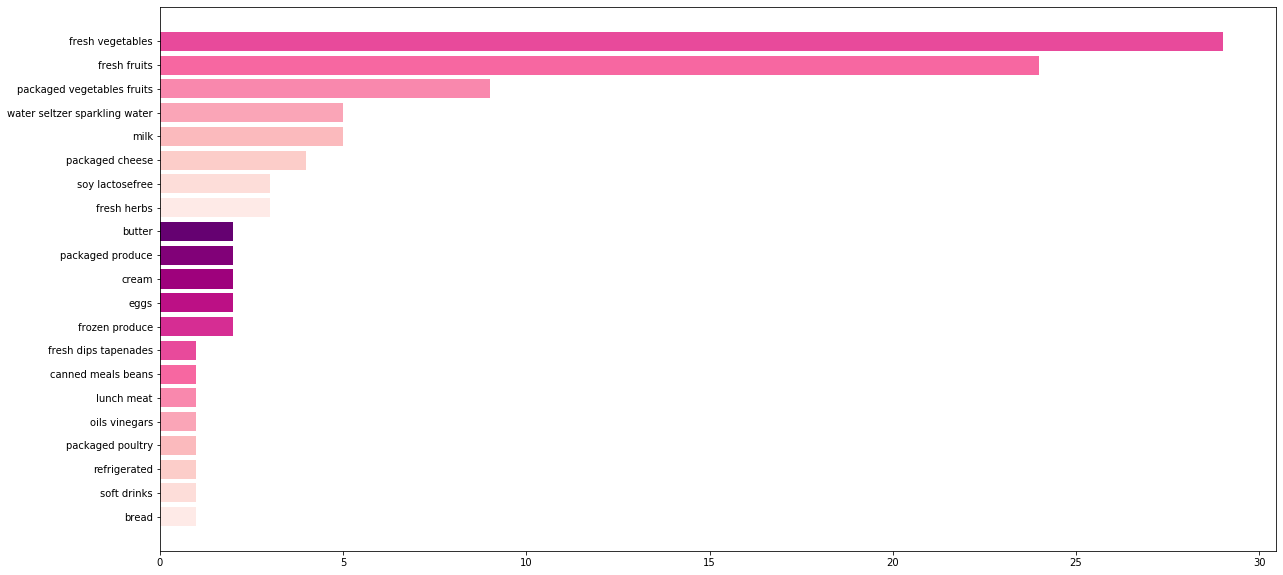

In [130]:
## products_info 테이블 파악_3
## 카테고리별 상품 갯수

data_category_name = df_product.pivot_table(values = 'name', index = ['category_name'], aggfunc='count')
data_category_name.reset_index(inplace=True)

colors=sns.color_palette('RdPu',len('category_name'))
data_category_name.sort_values('name',inplace=True)

plt.figure(figsize=(20,10))
plt.barh(data_category_name.category_name,data_category_name.name, color=colors)

## order_interval 결측치는 x / 공백값 존재 -> 치환

In [131]:
## train_x_past 테이블 파악_1

df_past.info()

## 일부 데이터(Colmn)값 Data Type 숫자형 변환 필요 (object -> float)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253972 entries, 0 to 1253971
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   order_id        1253972 non-null  object
 1   cstno           1253972 non-null  object
 2   order_number    1253972 non-null  object
 3   week_day        1253972 non-null  object
 4   order_hour      1253972 non-null  object
 5   order_interval  1253972 non-null  object
 6   add_order       1253972 non-null  object
 7   is_reordered    1253972 non-null  object
 8   product_id      1253972 non-null  object
dtypes: object(9)
memory usage: 86.1+ MB


In [132]:
## train_x_past 테이블파악_1-1
## df_past 데이터타입 변경 (object -> float)

df_past['order_number'] = df_past['order_number'].astype(float)
df_past['week_day'] = df_past['week_day'].astype(float)
df_past['order_hour'] = df_past['order_hour'].astype(float)
df_past['add_order'] = df_past['add_order'].astype(float)
df_past['is_reordered'] = df_past['is_reordered'].astype(float)

df_past.info()

## 5개 변수 숫자형 데이터 타입 변환 (order_id, cstno, product_id 제외)
## order_interval 변환시 오류로 상세 분석 진행

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253972 entries, 0 to 1253971
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   order_id        1253972 non-null  object 
 1   cstno           1253972 non-null  object 
 2   order_number    1253972 non-null  float64
 3   week_day        1253972 non-null  float64
 4   order_hour      1253972 non-null  float64
 5   order_interval  1253972 non-null  object 
 6   add_order       1253972 non-null  float64
 7   is_reordered    1253972 non-null  float64
 8   product_id      1253972 non-null  object 
dtypes: float64(5), object(4)
memory usage: 86.1+ MB


In [133]:
## train_x_past 테이블 파악_2
## 결측치(NULL) 확인

df_past.isnull().sum()

## 결측치 없음.

order_id          0
cstno             0
order_number      0
week_day          0
order_hour        0
order_interval    0
add_order         0
is_reordered      0
product_id        0
dtype: int64

<BarContainer object of 32 artists>

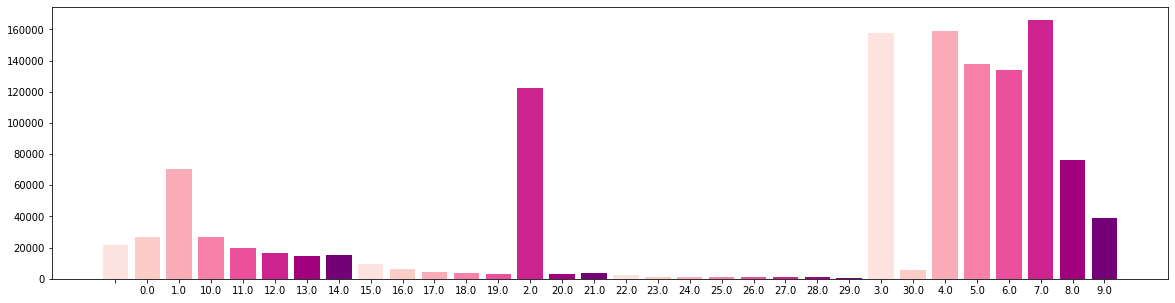

In [134]:
## train_x_past 테이블 파악_3

data_order_interval = df_past.pivot_table(values = 'order_id', index = ['order_interval'], aggfunc='count')
data_order_interval.reset_index(inplace=True)

colors=sns.color_palette('RdPu',len('order_id'))
plt.figure(figsize=(20,5))
plt.bar(data_order_interval.order_interval,data_order_interval.order_id, color=colors)

## order_interval 결측치는 x / 공백값 존재 -> 치환 

In [135]:
## train_x_past 테이블 파악_3-1
#order_interval 데이터타입 변경 (object -> float) / 공백값 존재 -> 치환 (0)

df_past = f""" SELECT replace(case when order_interval="" then "0.0" else order_interval end,".0","") as order_interval_new
                    , *
            FROM train_x_past A
            """

df_past = get_df(df_past, schema)
df_past['order_interval_new'] =df_past['order_interval_new'].astype(float)

df_past['order_number'] = df_past['order_number'].astype(float)
df_past['week_day'] = df_past['week_day'].astype(float)
df_past['order_hour'] = df_past['order_hour'].astype(float)
df_past['add_order'] = df_past['add_order'].astype(float)
df_past['is_reordered'] = df_past['is_reordered'].astype(float)

df_past.tail(10)

## df_past 테이블에 'order_interval_new' 데이터 추가

,order_interval_new,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
1253962,7.0,1449524,163819,46.0,1.0,16.0,7.0,3.0,1.0,24852
1253963,12.0,1471330,163819,7.0,1.0,10.0,12.0,1.0,1.0,24852
1253964,7.0,1518830,163819,2.0,2.0,11.0,7.0,5.0,1.0,24852
1253965,13.0,1714563,163819,3.0,1.0,16.0,13.0,1.0,1.0,24852
1253966,7.0,1727821,163819,38.0,1.0,11.0,7.0,14.0,1.0,24852
1253967,13.0,1902783,163819,47.0,0.0,19.0,13.0,2.0,1.0,24852
1253968,6.0,1969590,163819,42.0,1.0,15.0,6.0,3.0,1.0,24852
1253969,7.0,2549215,163819,9.0,1.0,11.0,7.0,1.0,1.0,24852
1253970,7.0,3103211,163819,39.0,1.0,14.0,7.0,3.0,1.0,24852
1253971,7.0,3207262,163819,8.0,1.0,12.0,7.0,1.0,1.0,24852


<BarContainer object of 31 artists>

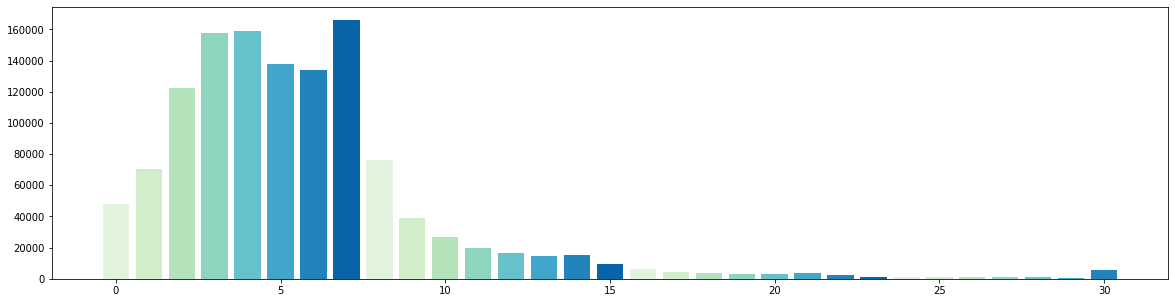

In [136]:
## train_x_past 테이블 파악_3_1
## order_inteval_new로 변수 변경 

data_order_interval_new = df_past.pivot_table(values = 'order_id', index = ['order_interval_new'], aggfunc='count')
data_order_interval_new.reset_index(inplace=True)
colors=sns.color_palette('GnBu',len('order_id'))

plt.figure(figsize=(20,5))
plt.bar(data_order_interval_new.order_interval_new,data_order_interval_new.order_id, color=colors)

## order_interval 결측치는 x / 공백값 존재 -> 치환 

In [137]:
## train_x_past 테이블 파악_4
## 고겍별로 구매 종류 갯수 파악 

past_table04 = f""" SELECT cstno, COUNT(*) AS CNT,  COUNT(distinct name) as 종류
            FROM train_x_past A
            LEFT JOIN products_info B
                   ON A.product_id = B.product_id
            GROUP BY 1
            ORDER BY CNT desc
            """


past_table04 = get_df(past_table04, schema)

past_table04.head(10)

,cstno,cnt,종류
0,150840,795,50
1,184451,766,48
2,103593,762,19
3,100787,751,49
4,54485,745,49
5,115495,736,56
6,95967,734,25
7,172806,733,47
8,175294,728,44
9,160106,727,49


<BarContainer object of 99 artists>

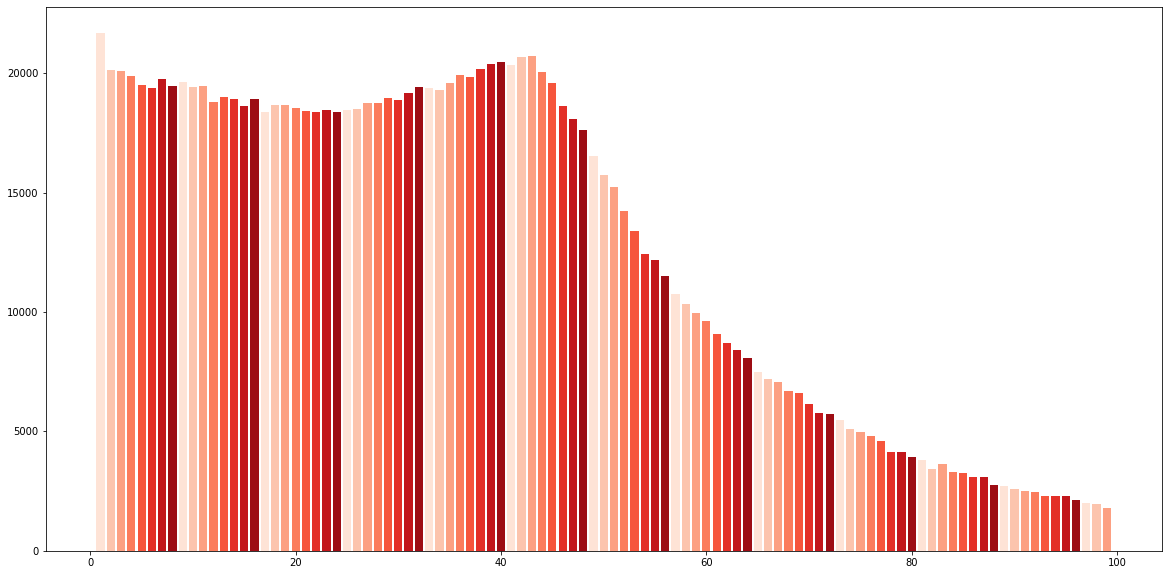

In [138]:
## train_x_past 테이블 파악_5
## 주문순서별(order_number) barplot

data_order_number = df_past.pivot_table(values = 'order_id', index = ['order_number'], aggfunc='count')
data_order_number.reset_index(inplace=True)
colors=sns.color_palette('Reds',len('order_id'))

plt.figure(figsize=(20,10))

plt.bar(data_order_number.order_number,data_order_number.order_id, color=colors)

## order_number 공백값없음 ->

<BarContainer object of 7 artists>

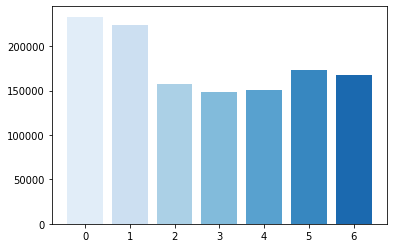

In [139]:
## train_x_past 테이블 파악_6
## 날자별(week_day) barplot

data_week_day = df_past.pivot_table(values = 'order_id', index = ['week_day'], aggfunc='count')
data_week_day.reset_index(inplace=True)
colors=sns.color_palette('Blues',len('order_id'))
plt.bar(data_week_day.week_day,data_week_day.order_id, color=colors)

## week_day 공백값 없음 

<BarContainer object of 93 artists>

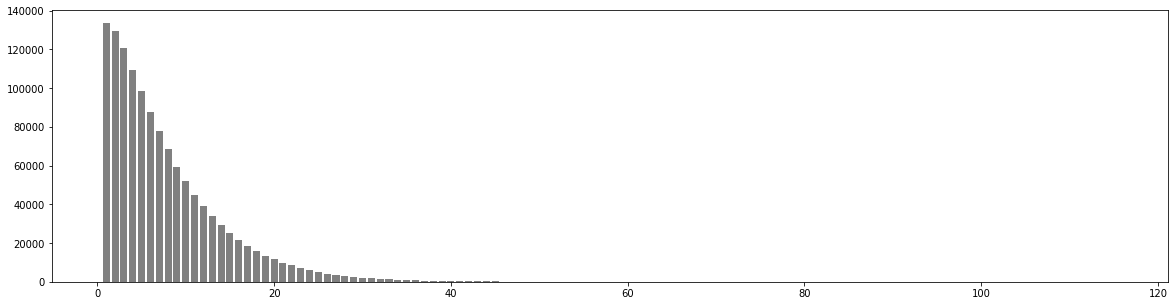

In [140]:
## train_x_past 테이블 파악_7
## 장바구니별(add_order) barplot
data_add_order = df_past.pivot_table(values = 'order_id', index = ['add_order'], aggfunc='count')
data_add_order.reset_index(inplace=True)

plt.figure(figsize=(20,5))
plt.bar(data_add_order.add_order,data_add_order.order_id, color='gray')

## add_order 공백값 x

<BarContainer object of 24 artists>

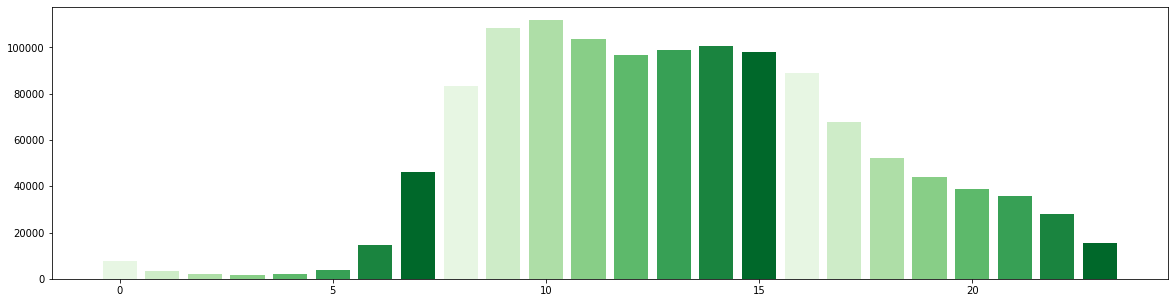

In [141]:
## train_x_past 테이블 파악_3
## 주문시간별(order_hour) barplot
data_order_hour = df_past.pivot_table(values = 'order_id', index = ['order_hour'], aggfunc='count')
data_order_hour.reset_index(inplace=True)
colors=sns.color_palette('Greens',len('order_id'))
plt.figure(figsize=(20,5))

plt.bar(data_order_hour.order_hour,data_order_hour.order_id, color=colors)

<BarContainer object of 2 artists>

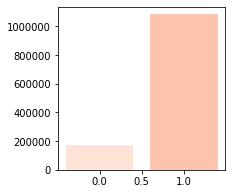

In [142]:
## train_x_past 테이블 파악_3
## 재구매여부(is_reordered) barplot

data_is_reordered = df_past.pivot_table(values = 'order_id', index = ['is_reordered'], aggfunc='count')
data_is_reordered.reset_index(inplace=True)
colors=sns.color_palette('Reds',len('order_id'))


plt.figure(figsize=(3,3))

plt.bar(data_is_reordered.is_reordered,data_is_reordered.order_id, color=colors)

<BarContainer object of 100 artists>

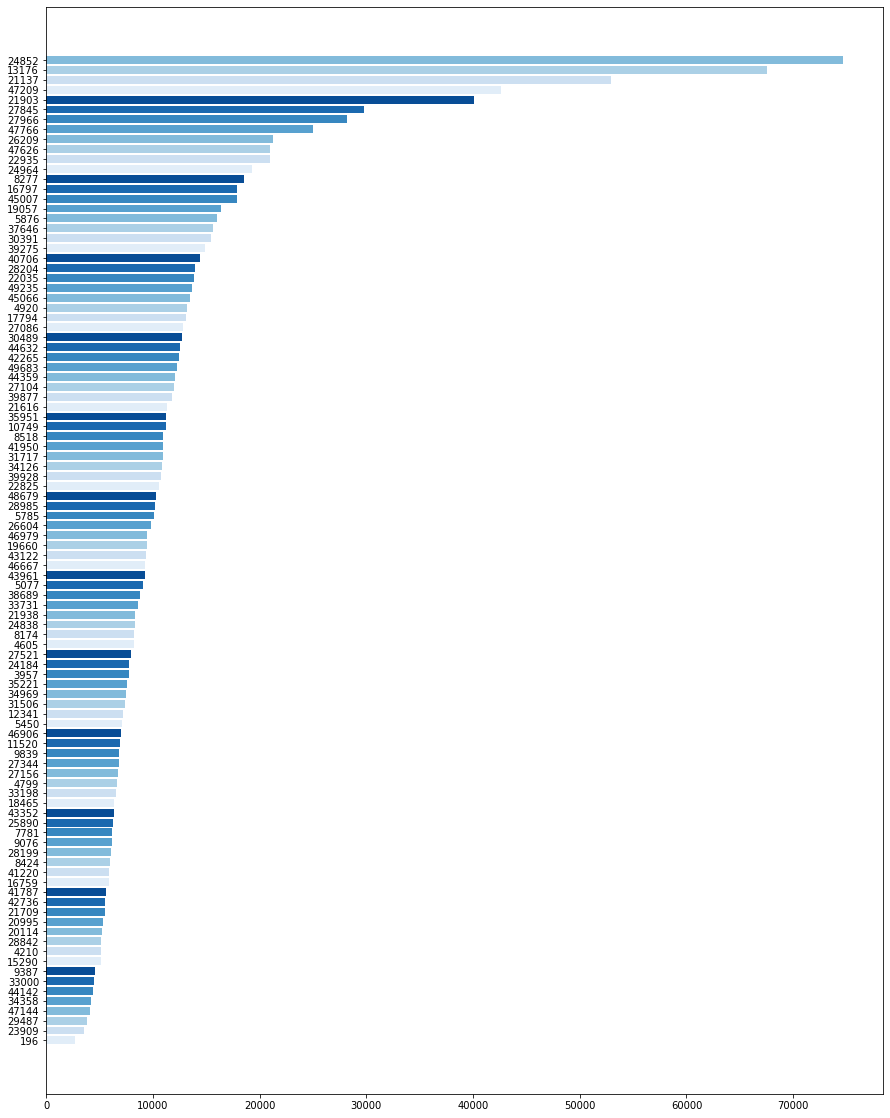

In [143]:
## train_x_past 테이블 파악_3
## 재구매여부(is_reordered) barplot

data_product_id = df_past.pivot_table(values = 'order_id', index = ['product_id'], aggfunc='count').sort_index(ascending=True)
data_product_id.reset_index(inplace=True)

data_product_id.sort_values('order_id',inplace=True)
colors=sns.color_palette('Blues',len('order_id'))


plt.figure(figsize=(15,20))
##df_sorted = df_past.sort_values('product_id')
plt.barh(data_product_id.product_id,data_product_id.order_id, color=colors)

In [144]:
## train_x_current 테이블 파악
df_current.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24424 entries, 0 to 24423
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        24424 non-null  object
 1   cstno           24424 non-null  object
 2   order_number    24424 non-null  object
 3   week_day        24424 non-null  object
 4   order_hour      24424 non-null  object
 5   order_interval  24424 non-null  object
 6   add_order       24424 non-null  object
 7   is_reordered    24424 non-null  object
dtypes: object(8)
memory usage: 1.5+ MB


In [145]:
## train_x_current 테이블파악_1-1
## df_current 데이터타입 변경 (object -> float)
## train_x_past 와 동일한 구조로 order_interval_new 생성

df_current = f""" SELECT replace(case when order_interval="" then "0.0" else order_interval end,".0","") as order_interval_new
                         , *
                 FROM train_x_current 
            """

df_current = get_df(df_current, schema)

df_current['order_interval_new'] = df_current['order_interval_new'].astype(float)
df_current['order_number'] = df_current['order_number'].astype(float)
df_current['week_day'] = df_current['week_day'].astype(float)
df_current['order_hour'] = df_current['order_hour'].astype(float)
df_current['add_order'] = df_current['add_order'].astype(float)
df_current['is_reordered'] = df_current['is_reordered'].astype(float)

df_current.info()

## 5개 변수 숫자형 데이터 타입 변환 (order_id, cstno, product_id 제외)
## order_interval 변환시 오류로 상세 분석 진행

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24424 entries, 0 to 24423
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_interval_new  24424 non-null  float64
 1   order_id            24424 non-null  object 
 2   cstno               24424 non-null  object 
 3   order_number        24424 non-null  float64
 4   week_day            24424 non-null  float64
 5   order_hour          24424 non-null  float64
 6   order_interval      24424 non-null  object 
 7   add_order           24424 non-null  float64
 8   is_reordered        24424 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.7+ MB


In [146]:
## train_x_current 결측치(NULL) 확인
df_current.isnull().sum()

## 결측치 없음.

order_interval_new    0
order_id              0
cstno                 0
order_number          0
week_day              0
order_hour            0
order_interval        0
add_order             0
is_reordered          0
dtype: int64

In [147]:
## train_x_current 테이블 파악_1
## is_reordered 별로 고객수, 건수 파악

current_table01 = f""" SELECT is_reordered, count(distinct cstno) as 고객수, count(*) as 구매건수
                        FROM test_x_current A
                        group by is_reordered
                        """

current_table01 = get_df(current_table01, schema)
current_table01.head(10)

,is_reordered,고객수,구매건수
0,0,1084,1469
1,1,4059,14657


In [148]:
## train_y 테이블 파악
df_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24424 entries, 0 to 24423
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  24424 non-null  object
dtypes: object(1)
memory usage: 190.9+ KB


## Chapter 2. 분석 방향 설정

- 데이터 구조 및 테이블, 칼럼별 상호 연관관계에 대해 파악한 후 분석 방향에 대해 설정함

<p style="font-weight:bold"> 　1. 추천할 상품을 크게 두가지로 나누어 제시함<br>
　　- 고객별 해당 상품을 과거에 구매한 적이 있는 상품(Is_reordered = 1)과<br>
　　- 해당 상품을 과거에 구매한 적이 없는 상품(is_reordered = 0)으로 구분하여 추천모델 생성<br></p>

<p style="font-weight:bold">　2. Past와 Current의 모든(최대한 많은) 정보를 독립변수로 보고, Product_y를 종속변수로 설정하여 분석을 진행</p><br>

<p style="font-weight:bold">　3. 고객별로 모든 상품(x100)에 대하여 구매 여부를 이항 종속변수로 놓고 해당 사건이 일어날 확률(구매)을 높은 순서대로 제시</p>

## Chapter 3. 의사결정을 위한 방법론적 분석 (다양한 분석 모형 탐색)

### 1. 사람들이 가장 많이 구매하는 상품 제시

In [149]:
## train_x_current 결과 test1

## train_x_past에사 가장 많이 구매한 상품 banana (product_id='24852') 
## 두번째로 많이 구매한 상품 bags of banana (product_id='13176')
## 과거에 바나나 구매이력있는 사람들은 banana, 없으면 bags of banana


test01 = f""" SELECT A.* , CASE WHEN B.cstno IS NOT NULL THEN '24852' ELSE '13176' END AS answer
            FROM train_x_current A
            left join (select cstno
                   from train_x_past
                   WHERE product_id='24852'
                  group by cstno) B
            on A.cstno=B.cstno
            """
test01 = get_df(test01, schema)

test01.head(10)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,answer
0,806422,41116,47,5,18,3.0,4,1,24852
1,2146033,127113,45,1,10,7.0,24,1,24852
2,3055498,140168,45,5,10,26.0,11,1,13176
3,3267527,60604,52,0,16,8.0,2,1,24852
4,3125992,136554,46,4,9,5.0,2,0,24852
5,2883377,30098,45,0,15,13.0,19,0,24852
6,879062,138549,50,5,16,7.0,4,1,24852
7,3234080,42711,100,1,9,5.0,11,1,13176
8,2026101,114720,44,0,20,6.0,2,1,24852
9,1732236,182942,49,0,15,21.0,2,1,24852


In [150]:
check01 = test01.join(df_y)

group_df=check01.groupby(['answer','product_id'])
group_df.size()

answer  product_id
13176   10749         106
        11520          65
        12341          91
        13176         843
        15290          37
                     ... 
24852   8424          160
        8518          187
        9076           84
        9387           61
        9839           75
Length: 200, dtype: int64

### 2. 과거에 가장 많이 구매한 상품 제시

In [151]:
## train_x_current 결과 test2

## 고객이 train_x_past 산 상품 중 비중이 가장 큰 상품을 추천 (WHERE T1.pd_cnt=2  AND T.is_reordered='1') 

test02 = f"""  with base1 as (SELECT A.cstno, A.product_id , cnt/ant*100 AS PD_R , prd_cnt
                            FROM (SELECT cstno,product_id, count(*) as cnt  
                                  from train_x_past
                                  group by cstno,product_id) as  A
                            left join (SELECT cstno, count(*) as ant, count(distinct product_id) as prd_cnt
                                       FROM train_x_past
                                       group by cstno
                                      ) B
                            on A.cstno=B.cstno
                            )
               , base2 as (select a.*, rank() over(partition by cstno order by  PD_R desc, product_id) as v_rank 
                            from base1 a
                            )
                            
                          SELECT T.* , t2.product_id as answer , prd_cnt , pd_r , ROWID
                            FROM (SELECT *, ROW_NUMBER() OVER ( ORDER BY ( NULL) ) AS ROWID FROM train_x_current) T
                             join (select cstno, COUNT(DISTINCT product_id) AS pd_cnt
                                   from train_x_past
                                  group by cstno) T1
                            on T.cstno=T1.cstno 
                            left join (select * from base2 where v_rank=1) t2
                            on T.cstno=t2.cstno
                        ORDER BY ROWID   
        
            """
test02= get_df(test02, schema)

test02.info()

##하단에 정답룰 쿼리 만들어보기 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24424 entries, 0 to 24423
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        24424 non-null  object 
 1   cstno           24424 non-null  object 
 2   order_number    24424 non-null  object 
 3   week_day        24424 non-null  object 
 4   order_hour      24424 non-null  object 
 5   order_interval  24424 non-null  object 
 6   add_order       24424 non-null  object 
 7   is_reordered    24424 non-null  object 
 8   rowid           24424 non-null  int64  
 9   answer          24424 non-null  object 
 10  prd_cnt         24424 non-null  int64  
 11  pd_r            24424 non-null  float64
 12  rowid           24424 non-null  int64  
dtypes: float64(1), int64(3), object(9)
memory usage: 2.4+ MB


### 3. 고객별 Order_interval을 고려하여 재구매 주기가 도래한 상품 확인

In [152]:
## train_x_current 결과 test3

## 고객별로 order_interval별로 가장 많이 구매 한 상품 조인
                
test03 = f""" with base1 as (SELECT A.cstno,A.order_interval, A.product_id , cnt/ant*100 AS PD_R_oi , prd_cnt
                            FROM (SELECT cstno,product_id, order_interval, count(*) as cnt  
                                  from train_x_past
                                  group by cstno,product_id, order_interval) as  A
                            left join (SELECT cstno , order_interval, count(*) as ant, count(distinct product_id) as prd_cnt
                                       FROM train_x_past
                                       group by cstno, order_interval
                                      ) B
                            on A.cstno=B.cstno
                            AND A.order_interval=B.order_interval  
                            ORDER BY A.order_interval
                                            )
               , base2 as (select a.*, rank() over(partition by cstno order by  PD_R_oi desc, product_id) as v_rank 
                            from base1 a
                            )
                          SELECT T.* , t2.product_id as answer2 , prd_cnt , PD_R_oi , ROWID
                            FROM (SELECT *, ROW_NUMBER() OVER ( ORDER BY ( NULL) ) AS ROWID FROM train_x_current) T
                             join (select cstno, COUNT(DISTINCT product_id) AS pd_cnt
                                   from train_x_past
                                  group by cstno) T1
                            on T.cstno=T1.cstno 
                            left join (select * from base2 where v_rank=1) t2
                            on T.cstno=t2.cstno
                            and T.order_interval=t2.order_interval
                        ORDER BY ROWID
                        
                          
              
        
            """
test03 = get_df(test03, schema)

check03 = test03.join(df_y)

check03.head(10)

## 고객별로 order_interval별로 가장 많이 구매 한 상품 조인 => 생각 보다 많이 조인되진 않음

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,rowid,answer2,prd_cnt,pd_r_oi,rowid,product_id
0,806422,41116,47,5,18,3.0,4,1,1,None,NaN,NaN,1,21709
1,2146033,127113,45,1,10,7.0,24,1,2,None,NaN,NaN,2,21709
2,3055498,140168,45,5,10,26.0,11,1,3,None,NaN,NaN,3,21709
3,3267527,60604,52,0,16,8.0,2,1,4,None,NaN,NaN,4,21709
4,3125992,136554,46,4,9,5.0,2,0,5,None,NaN,NaN,5,21709
5,2883377,30098,45,0,15,13.0,19,0,6,None,NaN,NaN,6,21709
6,879062,138549,50,5,16,7.0,4,1,7,None,NaN,NaN,7,21709
7,3234080,42711,100,1,9,5.0,11,1,8,None,NaN,NaN,8,21709
8,2026101,114720,44,0,20,6.0,2,1,9,None,NaN,NaN,9,21709
9,1732236,182942,49,0,15,21.0,2,1,10,None,NaN,NaN,10,21709


### 4. 고객별 특정 시간대에 많이 구매하는 상품 확인

In [153]:
## train_x_current 결과 test4

##고객별로 order_hour별로 가장 많이 구매 한 상품 조인
                 
test04 = f""" with base1 as (SELECT A.order_hour, A.product_id , cnt/ant*100 AS PD_R_oh
                            FROM (SELECT product_id, order_hour, count(*) as cnt  
                                  from train_x_past
                                  group by product_id, order_hour) as  A
                            left join (SELECT order_hour, count(*) as ant
                                       FROM train_x_past
                                       group by order_hour
                                      ) B
                            on A.order_hour=B.order_hour  
                            ORDER BY  A.order_hour, A.product_id
                                            )
               , base2 as (select a.*, rank() over(partition by order_hour order by  PD_R_oh desc) as v_rank 
                            from base1 a
                            )
                          SELECT T.* , t2.product_id as answer3 , ROWID
                            FROM (SELECT *, ROW_NUMBER() OVER ( ORDER BY ( NULL) ) AS ROWID FROM train_x_current) T
                             join (select cstno, COUNT(DISTINCT product_id) AS pd_cnt
                                   from train_x_past
                                  group by cstno) T1
                            on T.cstno=T1.cstno 
                            left join (select * from base2 where v_rank=1) t2
                            on T.order_hour=t2.order_hour
                        ORDER BY ROWID
                        
                          
              
        
            """
test04 = get_df(test04, schema)
check04 = test04.join(df_y)

check04.head(10)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,rowid,answer3,rowid,product_id
0,806422,41116,47,5,18,3.0,4,1,1,24852,1,21709
1,2146033,127113,45,1,10,7.0,24,1,2,24852,2,21709
2,3055498,140168,45,5,10,26.0,11,1,3,24852,3,21709
3,3267527,60604,52,0,16,8.0,2,1,4,24852,4,21709
4,3125992,136554,46,4,9,5.0,2,0,5,24852,5,21709
5,2883377,30098,45,0,15,13.0,19,0,6,24852,6,21709
6,879062,138549,50,5,16,7.0,4,1,7,24852,7,21709
7,3234080,42711,100,1,9,5.0,11,1,8,24852,8,21709
8,2026101,114720,44,0,20,6.0,2,1,9,24852,9,21709
9,1732236,182942,49,0,15,21.0,2,1,10,24852,10,21709


### 5. 고객별 과거 구매이력을 통해 상품별로 구매율 높은 순서대로 추천

In [154]:
## train_x_current 결과 test5

## 고객별 한가지의 상품만 추천(과거 최다구매 상품)

test05 = f"""    with base1 as (SELECT A.cstno, A.product_id , cnt/ant*100 AS PD_R , prd_cnt
                            FROM (SELECT cstno,product_id, count(*) as cnt  
                                  from train_x_past
                                  group by cstno,product_id) as  A
                            left join (SELECT cstno, count(*) as ant, count(distinct product_id) as prd_cnt
                                       FROM train_x_past
                                       group by cstno
                                      ) B
                            on A.cstno=B.cstno
                            )
               , base2 as (select a.*, rank() over(partition by cstno order by  PD_R desc, product_id) as v_rank 
                            from base1 a
                            )    
               , base3 as (  SELECT T.* , t2.product_id as answer , prd_cnt , pd_r , t3.product_id as train_y
                             FROM (SELECT *, ROW_NUMBER() OVER ( ORDER BY ( NULL) ) AS ROWID FROM train_x_current) T
                             join (select cstno, COUNT(DISTINCT product_id) AS pd_cnt
                                   from train_x_past
                                  group by cstno) T1
                             on T.cstno=T1.cstno 
                             left join (select * from base2 where v_rank=1) t2
                             on T.cstno=t2.cstno
                             left join ( SELECT product_id , ROW_NUMBER() OVER ( ORDER BY ( NULL) ) AS ROWID2 FROM train_y ) t3
                             on T.ROWID=t3.ROWID2
                             )
                select  sum(case when train_y=answer then 1 else 0 end)/count(*)*100 as 정답률
                from base3
                        
            """


test05  = get_df(test05, schema)
test05.head(10)

## 정답율 13%로 과거 구매 빈도가 유의하다고 판단.

,정답률
0,13.924828


### 6. 고객별 상품별 구매 빈도 매트릭스

In [155]:
## train_x_past 분석 test6

test06 = f""" SELECT cstno, product_id, count(*) as pnt
            FROM train_x_past A 
            group by cstno, product_id
        """
test06  = get_df(test06, schema)
check06=pd.pivot_table(test06, values='pnt', index='cstno', columns='product_id')
print(check06)

product_id  10749  11520  12341  13176  15290  16759  16797  17794  18465  \
cstno                                                                       
10000        15.0   15.0    NaN    6.0    5.0    1.0    NaN    4.0    1.0   
100001        7.0    NaN    NaN   41.0    1.0    NaN    NaN    7.0    2.0   
100046        NaN    NaN    NaN    2.0    NaN    NaN    2.0   12.0    NaN   
100071        1.0    3.0    NaN    6.0    NaN    NaN    NaN    NaN    NaN   
100108        NaN   32.0    NaN   20.0    NaN    NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
9981          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
99829         3.0    NaN    NaN    1.0    NaN   10.0    NaN    4.0    NaN   
99887         NaN    NaN    NaN    NaN    NaN   55.0    NaN    NaN    NaN   
99894         NaN    NaN    2.0    NaN    NaN    NaN    5.0    NaN    NaN   
99901         NaN    NaN    NaN    NaN    NaN    1.0    NaN    NaN    NaN   

In [156]:
## train_x_past 분석 test6_2
## 고객별 상품별 구매 빈도 매트릭스 - 구매율 표기

check06_2=(check06-check06.min())/(check06.max()-check06.min())
print(check06_2)

product_id     10749   11520     12341     13176     15290     16759  \
cstno                                                                  
10000       0.191781  0.1750       NaN  0.057471  0.071429  0.000000   
100001      0.082192     NaN       NaN  0.459770  0.000000       NaN   
100046           NaN     NaN       NaN  0.011494       NaN       NaN   
100071      0.000000  0.0250       NaN  0.057471       NaN       NaN   
100108           NaN  0.3875       NaN  0.218391       NaN       NaN   
...              ...     ...       ...       ...       ...       ...   
9981             NaN     NaN       NaN       NaN       NaN       NaN   
99829       0.027397     NaN       NaN  0.000000       NaN  0.157895   
99887            NaN     NaN       NaN       NaN       NaN  0.947368   
99894            NaN     NaN  0.012821       NaN       NaN       NaN   
99901            NaN     NaN       NaN       NaN       NaN  0.000000   

product_id     16797     17794     18465     19057  ...  5785  

In [157]:
check06_2_1=check06_2.reset_index()
check06_2_1.index.names=['scaled_purchase_freq']
check06_2_1= pd.melt(check06_2_1,id_vars=['cstno'],value_name='scaled_purchase_freq').dropna()

print(check06_2_1.shape)
check06_2_1.head()

(170198, 3)


,cstno,product_id,scaled_purchase_freq
0,10000,10749,0.191781
1,100001,10749,0.082192
3,100071,10749,0.000000
6,100142,10749,0.027397
9,100198,10749,0.205479


In [158]:
## train_x_past 분석 test6_3
## 고객별 division별로 구매 빈도 매트릭스 

test06_3 = f""" with aaa1 as (SELECT  division_name , A.*
                        FROM train_x_past A
                        LEFT JOIN products_info B
                         ON A.product_id = B.product_id )
             SELECT cstno, division_name, count(*) as cnt
               FROM aaa1
           GROUP BY cstno,division_name
                      
            
        """
test06_3  = get_df(test06_3, schema)
check06_3=pd.pivot_table(test06_3, values='cnt', index='cstno', columns='division_name', fill_value=0)
print(check06_3)

division_name  bakery  beverages  canned goods  dairy eggs  deli  frozen  \
cstno                                                                      
10000              41          3             6          74     2       0   
100001              0         23             0          33     0       3   
100046              0          3             0           0     0       0   
100071              0          4             0          12     0       0   
100108              0          0             0          41     0       0   
...               ...        ...           ...         ...   ...     ...   
9981                0         32             0          18     0       0   
99829               1          0             1          17     8       8   
99887               0          0             0           0     0       0   
99894               0         49             0          58     3       0   
99901               0          0             0          55     0       3   

division_na

### 7. 항목별 상관분석

In [159]:
## train_x_past 분석 test7
##  항목별 상관분석
test07 = f""" 
            SELECT replace(case when order_interval="" then "0.0" 
                                    else order_interval 
                           end,".0","") as order_interval_new , *
            FROM train_x_past A
        """
test07  = get_df(test07, schema)

test07['week_day'] = test07['week_day'].astype(float)
test07['order_interval_new'] = test07['order_interval_new'].astype(float)
test07['order_hour'] = test07['order_hour'].astype(float)
test07['is_reordered'] = test07['is_reordered'].astype(float)


test07.corr()

,order_interval_new,week_day,order_hour,is_reordered
order_interval_new,1.000000,-0.044738,-0.047120,0.042881
week_day,-0.044738,1.000000,0.020049,0.000480
order_hour,-0.047120,0.020049,1.000000,-0.008607
is_reordered,0.042881,0.000480,-0.008607,1.000000


### 8. 고객별 주문 건 확인

In [160]:
## train_x_current 분석 test8

##train_x_current 고객별 구매 데이터 체크 


test08 = f""" with base as ( SELECT T.* , t3.product_id 
                             FROM (SELECT *, ROW_NUMBER() OVER ( ORDER BY ( NULL) ) AS ROWID
                                  FROM train_x_current) t
                             left join ( SELECT product_id , ROW_NUMBER() OVER ( ORDER BY ( NULL) ) AS ROWID2 
                                         FROM train_y ) t3
                             on T.ROWID=t3.ROWID2           
                             )
            , base2 as (select cstno
                             , count(distinct product_id) as pnt, count(distinct order_id) as 주문건
                             , count(*) as 건수 
                        from base
                        group by cstno
                        order by pnt desc
                            )
                    select *
                    from base2                   
          """                                  
test08  = get_df(test08, schema)
test08.head(10)

,cstno,pnt,주문건,건수
0,100287,2,1,2
1,58449,5,1,5
2,126760,6,1,6
3,37804,6,1,6
4,180408,4,1,4
5,7660,1,1,1
6,141102,5,1,5
7,4166,8,1,8
8,107071,1,1,1
9,194947,2,1,2


### 9. 장바구니 분석 사전준비 _ 신뢰도 / 지지도  / 향상도

In [161]:
import itertools # 조합만들때 필요

In [162]:
# train_past & product _info join
##df_past10 = pd.merge(df_past, df_product, on = 'product_id', how = 'left')

In [163]:
## 신뢰도/지지도/향상도 분석 진행을 위한 DATA SET 준비
sql10 = f""" with aaa1 as (SELECT replace(case when order_interval="" then "0.0" else order_interval end,".0","") as order_interval_new
                               , category_name , A.*
                        FROM train_x_past A
                        LEFT JOIN products_info B
                         ON A.product_id = B.product_id )
             , aaa2 as (SELECT cstno, category_name, count(*) as cnt
                        FROM aaa1
                        GROUP BY cstno,category_name
                        )
             select cstno, category_name
                    , case when cnt > 0 then 1
                           else 0 end as cnt2
                from aaa2
            
        """
df_past10  = get_df(sql10, schema)
df_matrix10=pd.pivot_table(df_past10, values='cnt2', index='cstno', columns='category_name', fill_value=0)
print(df_matrix10)

category_name  bread  butter  canned meals beans  cream  eggs  \
cstno                                                           
10000              1       1                   1      1     1   
100001             0       0                   0      0     1   
100046             0       0                   0      0     0   
100071             0       0                   0      0     1   
100108             0       0                   0      0     1   
...              ...     ...                 ...    ...   ...   
9981               0       0                   0      1     0   
99829              1       1                   1      0     0   
99887              0       0                   0      0     0   
99894              0       0                   0      1     0   
99901              0       0                   0      1     0   

category_name  fresh dips tapenades  fresh fruits  fresh herbs  \
cstno                                                            
10000                 

In [164]:
df_past10.head(20)

df_past10.info('category_name')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50352 entries, 0 to 50351
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cstno          50352 non-null  object
 1   category_name  50352 non-null  object
 2   cnt2           50352 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [165]:
new_columns10 = df_matrix10.columns.str.strip().to_list()

In [166]:
df_matrix10.columns = new_columns10

In [167]:
df_matrix10.head(2)

,bread,butter,canned meals beans,cream,eggs,fresh dips tapenades,fresh fruits,fresh herbs,fresh vegetables,frozen produce,...,milk,oils vinegars,packaged cheese,packaged poultry,packaged produce,packaged vegetables fruits,refrigerated,soft drinks,soy lactosefree,water seltzer sparkling water
cstno,,,,,,,,,,,,,,,,,,,,,
10000,1,1,1,1,1,0,1,1,1,0,...,1,1,1,0,0,1,0,0,1,1
100001,0,0,0,0,1,0,1,1,1,1,...,0,0,1,0,0,1,1,0,1,1


In [168]:
def support(df_matrix, item_1st) :
        return (df_matrix[(item_1st)].sum(axis=1)==len(item_1st)).mean()

In [169]:
# support 함수 + 최소지지도 만족하는 조합 찾는 함수 만들기
rslt = support(df_matrix10, ['bread'])
rslt2 = support(df_matrix10, ['butter'])
print(rslt)
print(rslt2)

0.1483188257381806
0.32275132275132273


In [170]:
print (df_matrix10.isnull().any().sum())
print (df_matrix10[df_matrix10 > 1].any().sum())

0
0


In [171]:
def support_me(df_matrix,items_1st) :
    items_1st = items_1st if isinstance(items_1st,list) else list(items_1st)
    a = np.sum(df_matrix.loc[:,items_1st].sum(axis=1)==len(items_1st))
    b = df_matrix.loc[:,items_1st].shape[0]
    return a/b

In [172]:
rslt01 = support_me(df_matrix10, ('bread','butter'))
rslt02 = support_me(df_matrix10, ['fresh fruits'])
print(rslt01,rslt02)

0.04915514592933948 0.9918074756784434


In [173]:
## 모든 조합에 대해서, 최소 지지도 값을 넘는 조합 만들기
def make_all_set_over_support(df_matrix, support_threshold):
    items = []
    single_items = [ col for col in df_matrix.columns if support_me(df_matrix, [col]) > support_threshold]
    
    size = 2 ## 2개 조합부터
    while True: 
        new_items = []
        for item_cand in itertools.combinations(single_items, size):
            #print
            if support_me(df_matrix, item_cand)>support_threshold:
                new_items.append(list(item_cand))
        if len(new_items)==0: ## 가능ㅈ합이 넘어선 파라미터가 입력되면 빈 list return.
            break
        else:
            items+=new_items
            size+=1
    items += [ [s] for s in single_items]
    return items

In [174]:
over_support_1st = make_all_set_over_support(df_matrix10,0.9) # 0.05로하면 2개짜리조합도가능, 0.07일 경우는 1개조합만 가능
over_support_1st

[['fresh fruits', 'fresh vegetables'],
 ['fresh fruits', 'packaged vegetables fruits'],
 ['fresh fruits'],
 ['fresh vegetables'],
 ['packaged vegetables fruits']]

In [175]:
## confidence 함수 만들기
def make_confidence_1st(df_matrix, item_set_over_support, confidence_threshold):
    r_1st = []
    for item1 in item_set_over_support:
       for item2 in item_set_over_support:
        if len(set(item1).intersection(set(item2)))==0:
            conf = support_me(df_matrix, set(item1).union(set(item2)))/support_me(df_matrix, item1)
            if conf > confidence_threshold:
                r_1st.append((item1, item2, conf))
        else:
            continue
    return sorted(r_1st, key=lambda x: x[2], reverse=True)

In [176]:
## lift 함수 만들기
def make_lift_1st(df_matrix, item_set_over_support, lift_threhsold):
    r_1st = []
    for item1 in item_set_over_support:
        for item2 in item_set_over_support:
            if len(set(item1).intersection(set(item2)))==0:
                lift = support_me(df_matrix, list(set(item1).union(set(item2))))
                lift /= support(df_matrix, item1)
                lift /= support(df_matrix, item2)
                if lift > lift_threhsold:
                   r_1st.append((item1, item2, lift))
            else:
                   continue
    return sorted(r_1st, key=lambda x: x[2], reverse=True)

In [177]:
## 결과 Print
print("over support list")
print(over_support_1st)
print("-------------------------")
print("over confidence list")
for a, b, conf in make_confidence_1st(df_matrix10, over_support_1st, 0.53):
    print("{} => {}: {}".format(a, b, conf))
print("-------------------------")
print("over lift list")
for a, b, lift in make_lift_1st(df_matrix10, over_support_1st, 5.6):
    print("{} => {}; {}".format(a,b, lift))
print("-------------------------")

over support list
[['fresh fruits', 'fresh vegetables'], ['fresh fruits', 'packaged vegetables fruits'], ['fresh fruits'], ['fresh vegetables'], ['packaged vegetables fruits']]
-------------------------
over confidence list
['fresh vegetables'] => ['fresh fruits']: 0.998488569809182
['packaged vegetables fruits'] => ['fresh fruits']: 0.9971367215461704
['fresh fruits', 'fresh vegetables'] => ['packaged vegetables fruits']: 0.9736991485335855
['fresh vegetables'] => ['packaged vegetables fruits']: 0.9733610428868317
['fresh vegetables'] => ['fresh fruits', 'packaged vegetables fruits']: 0.9722274702437181
['fresh fruits'] => ['packaged vegetables fruits']: 0.9588711065221133
['fresh fruits', 'packaged vegetables fruits'] => ['fresh vegetables']: 0.9235463029432878
['packaged vegetables fruits'] => ['fresh vegetables']: 0.9219756621331424
['packaged vegetables fruits'] => ['fresh fruits', 'fresh vegetables']: 0.9209019327129563
['fresh fruits'] => ['fresh vegetables']: 0.9094820168645672

## Chapter 4. 이항로지스틱 회귀분석을 통한 상품 추천 모형 생성

### 1. 분석용 테이블 생성 (X, Y)

In [178]:
## 데이터셋(독립변수)생성 1
## current. past 정보 활용하여 고객특성 테이블 생성
cst01 = f""" with curr as (
                     select cstno
                          , week_day as cr_week_day
                          , (case when cast(order_hour as int) between 9 and 18 then 1 else 0 end) as cr_일과시간여부                     
                          , cast(replace(order_interval,".0","")  as int) as cr_order_interval 
                          , count(*) as cr_주문건수
                          , sum(cast(is_reordered as int)) as  cr_reordered
                          , count(*)- sum(cast(is_reordered as int)) as cr_not_reordered
                          
                      from train_x_current 
                      group by 1,2,3,4

                    )
                        
                   select t.cstno 
                  , count(*) as 구매건수 
                  , count(distinct order_id) as 주문건수
                  , count(*)/count(distinct order_id) as 평균구매건수
                  , count(distinct product_id) as 구매한상품가짓수
                  , sum(CASE WHEN order_interval is not null then cast(replace(order_interval,".0","")  as int) else 0 end) 
                      /count(case when order_interval is not null then 1 else 0 end ) as p_avg
                  , count(distinct t.cstno) as 상품구매인
                  , sum(cast(week_day as int))/ count(*) as 평균요일
                  , sum(case when week_day in ('0','1') then 0 else 1 end)/ count(*) as 평일여부
                  , sum(cast(order_hour as int))/ count(*) as 평균구매시각
                  , sum(cast(add_order as int))/ count(*) as 평균add_order   
                  , cr_week_day
                  , cr_일과시간여부
                  , cr_주문건수
                  , cr_reordered
                  , cr_not_reordered
                  , t1.cr_order_interval   
                  , cr_week_day
             from train_x_past t
             left join curr  t1
             on t.cstno=t1.cstno
             group by t.cstno
                  , t1.cr_order_interval
                  , cr_주문건수
                  , cr_reordered
                  , cr_not_reordered
                  , t1.cr_order_interval        
                  , cr_week_day
                  , cr_week_day
                  , cr_일과시간여부                  
            """

cst01  = get_df(cst01, schema)
cst01.head(10)      
 

,cstno,구매건수,주문건수,평균구매건수,구매한상품가짓수,p_avg,상품구매인,평균요일,평일여부,평균구매시각,평균add_order,cr_week_day,cr_일과시간여부,cr_주문건수,cr_reordered,cr_not_reordered,cr_order_interval,cr_week_day
0,5684,360,49,7.346939,37,7.550000,1,2.386111,0.591667,13.722222,10.205556,1,1,7,7,0,5,1
1,140433,149,53,2.811321,31,6.449664,1,3.550336,0.798658,15.838926,5.986577,1,0,2,2,0,2,1
2,123016,429,56,7.660714,38,6.701632,1,2.617716,0.634033,12.748252,9.477855,5,0,11,10,1,4,5
3,92111,114,75,1.520000,24,2.807018,1,2.728070,0.605263,15.192982,4.728070,5,0,2,1,1,3,5
4,48500,215,52,4.134615,44,6.613953,1,2.641860,0.586047,11.609302,8.618605,4,1,6,6,0,7,4
5,11261,222,49,4.530612,38,8.490991,1,2.837838,0.711712,14.436937,7.418919,5,1,1,1,0,15,5
6,192941,294,75,3.920000,37,4.785714,1,3.136054,0.670068,13.251701,6.928571,0,0,2,2,0,3,0
7,129198,132,62,2.129032,26,4.121212,1,3.090909,0.719697,15.409091,4.424242,6,1,1,1,0,1,6
8,170248,399,95,4.200000,49,2.428571,1,2.679198,0.604010,11.812030,5.258145,0,1,3,3,0,2,0
9,126272,361,90,4.011111,46,3.080332,1,2.789474,0.628809,12.875346,7.470914,6,0,4,4,0,2,6


In [179]:
## train_x_past 
cst01.info()   


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5859 entries, 0 to 5858
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cstno              5859 non-null   object 
 1   구매건수               5859 non-null   int64  
 2   주문건수               5859 non-null   int64  
 3   평균구매건수             5859 non-null   float64
 4   구매한상품가짓수           5859 non-null   int64  
 5   p_avg              5859 non-null   float64
 6   상품구매인              5859 non-null   int64  
 7   평균요일               5859 non-null   float64
 8   평일여부               5859 non-null   float64
 9   평균구매시각             5859 non-null   float64
 10  평균add_order        5859 non-null   float64
 11  cr_week_day        5859 non-null   object 
 12  cr_일과시간여부          5859 non-null   int64  
 13  cr_주문건수            5859 non-null   int64  
 14  cr_reordered       5859 non-null   int64  
 15  cr_not_reordered   5859 non-null   int64  
 16  cr_order_interval  5859 

In [180]:
## 로지스틱 회귀분석 step01

## 고객별 모든 상품에 대한 구매확률 계산을 위해 [고객별 x 100] Row 테이블 생성

## 데이터셋(독립변수)생성 2
## current. past 정보 활용하여 생성된 고객테이블 바탕으로 
## 고객별 x 상품별 데이터셋(독립변수) 생성 (고객수 x 100)
 

##  target = 로지스틱 회귀분석 목적변수 *
##         = current에 대응하는 train_y [해당상품 구매 여부]* 

##  pnt= 고객단 구매상품 갯수 
##  p_rank = past [상품별 구매빈도 순위]
## 고객당구매건 = past [고객단 전체 구매 건수]
## 고객당상품구매건 = past [고객단 해당상품 구매 건수]
## 구매율 = [고객당상품구매건/고객당구매건]
## p_avg = past [고객당 해당상품 평균 구매주기(order_interval)] 
## is_reorder_new = 해당 상품 재구매여부
## is_reorder = current[재구매 건수]
## isnot_reorder = current[비재구매 건수]
## reoder합 = current[전체주문건수(is_reorder+isnot_reorder)]


##  col1 = past [1/고객단 구매상품 갯수 pnt] 
##  col2 = past [고객별 상품 구매수]
##  col3 = current [ week_day 범주화 금, 토, 일 = 0 / 월~목 = 1]
##  col4 = current [order_hour 9~6 then 1 else 0]
##  col5 = past [상품의 평균 order_interval 보다 고객단 해당상품 평균 order_interval 가 크면 1 else 0]
##       = 최초구매시 null 값의 경우 재구미시기가 도래하지 않았다고 봄 (0)
##  col6 = past [고객별 past 에서 가장 마지막 order_id 에 해당상품이 구매시 1 else 0 ]
##  col7 = past [전체 고객에 대한 상품별 구매수] 
##  col8 = past [상품별 add_order가 1인 횟수]


## [항목별 수정내용]
## col1 : 고객단 구매상품 갯수  ->  1/고객단 구매상품 갯수 
## col2 = 고객별 상품 구매율 (해당상품구매건수/전체구매건수)  ->  고객별 상품 구매수
## col3 = [current 토, 일 = 0 / 월~금 = 1]  ->  [current 금, 토, 일 = 0 / 월~금 = 1]



reg01 = f"""   with product as 
                    (  select product_id
                            
                            , count(*) as 총상품구매
                            , count(*)/count(distinct cstno) as 인당구매건
                            , count(distinct cstno) as 상품구매인
                            , sum(cast(week_day as int))/ count(*) as 평균요일
                            , sum(case when week_day in ('0','1') then 0 else 1 end)/ count(*) as 평일여부
                            , sum(cast(order_hour as int))/ count(*) as 평균구매시각
                            , sum(case when cast(order_hour as int) between 9 and 18 then 1 else 0 end)/ count(*) as 일과시간여부
                            , sum(cast(add_order as int))/ count(*) as 평균add_order
                            , rank() over (order by  count(*) desc) as p_rank
                            , sum(case when add_order	='1' then 1 else 0 end ) as col8
                       from train_x_past 
                       group by product_id    
                       
                     )
           , base1 as ( select p.cstno , product_id 
                            from (SELECT *, ROW_NUMBER() OVER ( ORDER BY ( NULL) ) AS ROWID
                                  FROM train_x_current) p
                            left join ( SELECT product_id , ROW_NUMBER() OVER ( ORDER BY ( NULL) ) AS ROWID2 
                                        FROM train_y ) p2
                             on p.ROWID=p2.ROWID2  
                          group by p.cstno , product_id
                           )
                           
                select r.cstno, r.product_id
                      , case when r.product_id=r1.product_id then 1 else 0 end as target
                      , pnt       
                      , 고객당구매건
                      , case when 고객당상품구매건 is null then 0 else 고객당상품구매건 end as 고객당상품구매건
                      , case when 고객당상품구매건 is null then 0 else 고객당상품구매건 / 고객당구매건 *100 end AS 구매율
                    
                      , p_avg
                      , case when 고객당상품구매건 is null then 0 else 1 end as is_reorder_new
                      , is_reorder, isnot_reorder
                      , p_rank
                      , is_reorder+isnot_reorder as reoder합
                      
                        , 1/pnt as col1
                      --, case when 고객당상품구매건 is null then 0 else 고객당상품구매건 / 고객당구매건 *100 end as col2
                      , case when 고객당상품구매건 is null then 0 else 고객당상품구매건 end as col2
                      , case when week_day in ('0','6','5') then 0 else 1 end as col3
                      , case when cast(order_hour as int)  between 9 and 18 then 1 else 0 end as col4
                      , case when cast(replace(order_interval,".0","") as int)<=nvl(p_avg,0) then 1 else 0 end as col5 
                      , nvl(최근구매여부,0) as col6
                      , 총상품구매 as col7
                      , col8
                    from ( SELECT t.cstno , t1.product_id  , week_day , order_hour , order_interval 
                            FROM train_x_current t
                            left join products_info t1
                            on 0=0
                            group by t.cstno , t1.product_id , week_day , order_hour , order_interval 
                            ) r
                left join base1 r1
                on r.cstno=r1.cstno  
                and r.product_id=r1.product_id   

                left join product r2
                on  r.product_id=r2.product_id   
                
                left join (select cstno, count(*) as 고객당구매건 , count(distinct product_id) as pnt
                           from train_x_past 
                           group by cstno) r3
                 on r.cstno=r3.cstno
               
                left join (select  y.cstno , y.product_id, count(*) as 고객당상품구매건
                                , sum(CASE WHEN order_interval is not null then cast(replace(order_interval,".0","")  as int) else 0 end) 
                                /count(case when order_interval is not null then 1 else 0 end ) as p_avg
                                , max(case when y2.order_id is not null then 1 else 0 end) as 최근구매여부          
                               from train_x_past y
                               left join ( select  cstno, order_id, order_number
                                                                , rank() over (partition by cstno
                                                                                order by cast(order_number as int) desc
                                                                                ) 
                                                                  as v_rank
                                         from train_x_past               
                                         group by cstno, order_id, order_number
                                         order by v_rank
                                        ) y2
                                    on y.order_id=y2.order_id       
                                    and y2.v_rank =1                
                                group by y.cstno, y.product_id
                
                ) r4
                 on r.cstno=r4.cstno    
                 and r.product_id=r4.product_id 
              
              left join (SELECT  cstno, sum(cast(is_reordered as int)) as is_reorder
                              , count(*)- sum(cast(is_reordered as int)) as isnot_reorder
                        FROM train_x_current t
                        group by cstno
                        ) r5
                 on r.cstno=r5.cstno     
           --   where r.product_id='24852'

            """
reg01  = get_df(reg01, schema)

reg01.head(10)       

##

,cstno,product_id,target,pnt,고객당구매건,고객당상품구매건,구매율,p_avg,is_reorder_new,is_reorder,...,p_rank,reoder합,col1,col2,col3,col4,col5,col6,col7,col8
0,111432,31506,0,31,296,9,3.040541,5.555556,1,10,...,66,11,0.032258,9,1,0,0,1,7436,900
1,91989,49683,0,42,273,1,0.366300,5.000000,1,4,...,32,6,0.023810,1,0,1,1,0,12278,901
2,136302,26209,0,14,114,2,1.754386,5.500000,1,2,...,9,2,0.071429,2,1,1,0,0,21216,1354
3,128206,30391,0,18,137,1,0.729927,8.000000,1,3,...,19,4,0.055556,1,1,1,1,0,15470,1002
4,32073,13176,0,20,145,3,2.068966,3.000000,1,2,...,2,3,0.050000,3,1,0,0,0,67514,12785
5,117493,44359,0,36,204,1,0.490196,6.000000,1,3,...,33,3,0.027778,1,0,0,0,0,12071,746
6,12670,21137,0,18,170,6,3.529412,4.833333,1,3,...,3,3,0.055556,6,0,1,0,0,52917,5083
7,190777,24964,0,48,318,22,6.918239,6.681818,1,8,...,12,8,0.020833,22,0,1,0,1,19332,1326
8,17084,46667,0,20,145,2,1.379310,7.500000,1,4,...,52,5,0.050000,2,1,0,1,0,9291,768
9,164974,19057,0,28,221,4,1.809955,5.250000,1,7,...,16,8,0.035714,4,0,1,0,0,16387,1425


### 2_1. 로지스틱 회귀분석 (X, Y)_ Split(학습세트, 평가세트)

In [181]:
## 로지스틱 회귀분석 step01_2

reg01.info()

##

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585900 entries, 0 to 585899
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   cstno           585900 non-null  object 
 1   product_id      585900 non-null  object 
 2   target          585900 non-null  int64  
 3   pnt             585900 non-null  int64  
 4   고객당구매건          585900 non-null  int64  
 5   고객당상품구매건        585900 non-null  int64  
 6   구매율             585900 non-null  float64
 7   p_avg           168847 non-null  float64
 8   is_reorder_new  585900 non-null  int64  
 9   is_reorder      585900 non-null  int64  
 10  isnot_reorder   585900 non-null  int64  
 11  p_rank          585900 non-null  int64  
 12  reoder합         585900 non-null  int64  
 13  col1            585900 non-null  float64
 14  col2            585900 non-null  int64  
 15  col3            585900 non-null  int64  
 16  col4            585900 non-null  int64  
 17  col5      

In [182]:
## 로지스틱 회귀분석 테스트 step01
## 회귀분석을 위한 설명변수 , 타겟변수 설정


train_features=reg01[['col1','col2','col3','col4','col5','col6','col7','col8']]
train_labels=reg01[['target']]


In [183]:
## 로지스틱 회귀분석 테스트 step02
## 설명변수 정규화(스케일링) - StandardScaler를 통해서 평균 0 표준편차 1로 변환

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)


In [184]:
## 로지스틱 회귀분석 테스트 step03
## 학습세트와 평가세트 분리하기

from sklearn.model_selection import train_test_split
train_x, test_x , train_y, test_y = train_test_split(train_features, train_labels)

In [185]:
## 로지스틱 회귀분석 테스트 step04
## 모델 생성 및 평가하기

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

train_y2=train_y.values.ravel()
test_y2=test_y.values.ravel()

result = model.fit(train_x,train_y2)

In [186]:
## 로지스틱 회귀분석 테스트 step05
## 회귀분석_적합률 확인1_(학습세트)

print(model.score(train_x,train_y2))

0.9612903225806452


In [187]:
## 로지스틱 회귀분석 테스트 step06
## 회귀분석_각 feature들의 계수(coefficients)확인

print(model.coef_)

[[-0.34015589  0.63884123 -0.05715723  0.00907969  0.26995915  0.30342024
   0.3477985  -0.23007074]]


In [188]:
## 로지스틱 회귀분석 테스트 step07
## 테스트셋으로 예측값 확인


print(model.predict(test_x))

[0 0 0 ... 0 0 0]


In [189]:
## 로지스틱 회귀분석 테스트 step07
## 테스트셋으로 예측률 확인

print(model.predict_proba(test_x))

[[0.98729771 0.01270229]
 [0.98871573 0.01128427]
 [0.98592073 0.01407927]
 ...
 [0.98822818 0.01177182]
 [0.95951494 0.04048506]
 [0.90464538 0.09535462]]


### 2_2. 로지스틱 회귀분석 (X, Y)_ 모든 설명변수를 포함하여 모형 생성

In [190]:
## 실제 적용 모형 ##
## 로지스틱 회귀분석 step01

features_raw_00=reg01[['cstno','target','product_id','p_rank','is_reorder_new','is_reorder','isnot_reorder','reoder합','col1','col2','col3','col4','col5','col6','col7','col8']]
labels_raw_00=reg01[['target']]
features_raw_00.head(10) 


,cstno,target,product_id,p_rank,is_reorder_new,is_reorder,isnot_reorder,reoder합,col1,col2,col3,col4,col5,col6,col7,col8
0,111432,0,31506,66,1,10,1,11,0.032258,9,1,0,0,1,7436,900
1,91989,0,49683,32,1,4,2,6,0.023810,1,0,1,1,0,12278,901
2,136302,0,26209,9,1,2,0,2,0.071429,2,1,1,0,0,21216,1354
3,128206,0,30391,19,1,3,1,4,0.055556,1,1,1,1,0,15470,1002
4,32073,0,13176,2,1,2,1,3,0.050000,3,1,0,0,0,67514,12785
5,117493,0,44359,33,1,3,0,3,0.027778,1,0,0,0,0,12071,746
6,12670,0,21137,3,1,3,0,3,0.055556,6,0,1,0,0,52917,5083
7,190777,0,24964,12,1,8,0,8,0.020833,22,0,1,0,1,19332,1326
8,17084,0,46667,52,1,4,1,5,0.050000,2,1,0,1,0,9291,768
9,164974,0,19057,16,1,7,1,8,0.035714,4,0,1,0,0,16387,1425


In [191]:
## 로지스틱 회귀분석 step01
## 회귀분석을 위한 설명변수만 features, 종속변수를 labels로 각각 분리

features_00=reg01[['col1','col2','col3','col4','col5','col6','col7','col8']]
labels_00=reg01[['target']]
features_00.head(10) 


,col1,col2,col3,col4,col5,col6,col7,col8
0,0.032258,9,1,0,0,1,7436,900
1,0.023810,1,0,1,1,0,12278,901
2,0.071429,2,1,1,0,0,21216,1354
3,0.055556,1,1,1,1,0,15470,1002
4,0.050000,3,1,0,0,0,67514,12785
5,0.027778,1,0,0,0,0,12071,746
6,0.055556,6,0,1,0,0,52917,5083
7,0.020833,22,0,1,0,1,19332,1326
8,0.050000,2,1,0,1,0,9291,768
9,0.035714,4,0,1,0,0,16387,1425


In [192]:
## 로지스틱 회귀분석 step01_1
## 데이터 확인 [5,859(Cstno) X 100(product_id)]

features_00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585900 entries, 0 to 585899
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   col1    585900 non-null  float64
 1   col2    585900 non-null  int64  
 2   col3    585900 non-null  int64  
 3   col4    585900 non-null  int64  
 4   col5    585900 non-null  int64  
 5   col6    585900 non-null  int64  
 6   col7    585900 non-null  int64  
 7   col8    585900 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 35.8 MB


In [193]:
## 로지스틱 회귀분석 step02
## 설명변수 정규화 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

features_00 = scaler.fit_transform(features_00)



In [194]:
## 로지스틱 회귀분석 step03
## 회귀분석 ## 실제 모델 생성 

from sklearn.linear_model import LogisticRegression

labels2_00=labels_00.values.ravel()

model = LogisticRegression()
model.fit(features_00,labels2_00)

LogisticRegression()

In [195]:
## 로지스틱 회귀분석 step04
## 회귀분석_적합률 (평가)

print(model.score(features_00,labels2_00))

0.9614985492404847


In [196]:
## 로지스틱 회귀분석 step05
## 회귀분석_각 feature들의 계수(coefficients)확인

print(model.coef_)

[[-0.30828767  0.64018381 -0.05608526  0.00179807  0.27433569  0.30382317
   0.34629245 -0.23070323]]


In [197]:
## 로지스틱 회귀분석 step06
## 회귀분석_정답예측률_살것이라고 모형에서 예측하는 건수

pro=model.predict_proba(features_00)
print(model.predict(features_00))
model.predict(features_00).sum()


[0 0 0 ... 0 0 0]


10024

In [198]:
## 로지스틱 회귀분석 step07
## 회귀분석_정답예측률을 컬럼값으로 변환

dt_proba_00 = pd.DataFrame(model.predict_proba(features_00))
dt_proba_00.head(10)

,0,1
0,0.871903,0.128097
1,0.963720,0.036280
2,0.982290,0.017710
3,0.969870,0.030130
4,0.973465,0.026535
5,0.981947,0.018053
6,0.944808,0.055192
7,0.519184,0.480816
8,0.970805,0.029195
9,0.974967,0.025033


In [199]:
## 로지스틱 회귀분석 step08
## 기존의 회귀분석 준비 테이블하고 결합

##train_features3 = train_features2.reset_index(drop=True)
df_model_01_00= pd.concat([dt_proba_00,features_raw_00],axis=1,)
df_model_01_00.head(10)

df_model_01_00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585900 entries, 0 to 585899
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   0               585900 non-null  float64
 1   1               585900 non-null  float64
 2   cstno           585900 non-null  object 
 3   target          585900 non-null  int64  
 4   product_id      585900 non-null  object 
 5   p_rank          585900 non-null  int64  
 6   is_reorder_new  585900 non-null  int64  
 7   is_reorder      585900 non-null  int64  
 8   isnot_reorder   585900 non-null  int64  
 9   reoder합         585900 non-null  int64  
 10  col1            585900 non-null  float64
 11  col2            585900 non-null  int64  
 12  col3            585900 non-null  int64  
 13  col4            585900 non-null  int64  
 14  col5            585900 non-null  int64  
 15  col6            585900 non-null  int64  
 16  col7            585900 non-null  int64  
 17  col8      

In [200]:
## 로지스틱 회귀분석 step09_1
## is_reordered 1인 경우는 기존 구매했던 상품에서 회귀분석 예측 모델값을 제시

df_model_01_00['rank_by_max'] = df_model_01_00.groupby('cstno')[1].rank(method='first',ascending=False)
##

df_model_01_00['rank'] = df_model_01_00.groupby('cstno')[1].rank(method='first',ascending=False)


df_model_02_1_00 = df_model_01_00[df_model_01_00['rank_by_max']<=df_model_01_00['is_reorder']]

df_model_03_1_00 = df_model_02_1_00[ (df_model_02_1_00['is_reorder']>=df_model_02_1_00['rank_by_max']) & (df_model_02_1_00['is_reorder_new']!=0) ]


df_model_03_1_00.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22979 entries, 0 to 170196
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   0               22979 non-null  float64
 1   1               22979 non-null  float64
 2   cstno           22979 non-null  object 
 3   target          22979 non-null  int64  
 4   product_id      22979 non-null  object 
 5   p_rank          22979 non-null  int64  
 6   is_reorder_new  22979 non-null  int64  
 7   is_reorder      22979 non-null  int64  
 8   isnot_reorder   22979 non-null  int64  
 9   reoder합         22979 non-null  int64  
 10  col1            22979 non-null  float64
 11  col2            22979 non-null  int64  
 12  col3            22979 non-null  int64  
 13  col4            22979 non-null  int64  
 14  col5            22979 non-null  int64  
 15  col6            22979 non-null  int64  
 16  col7            22979 non-null  int64  
 17  col8            22979 non-null

In [201]:
## 로지스틱 회귀분석 step09_1
## is_reordered 1인 경우는 기존 구매했던 상품에서 회귀분석 예측 모델값을 제시


df_model_00_1_00 = df_model_01_00[(df_model_01_00['is_reorder_new']!=0) ]
df_model_00_1_00=pd.DataFrame(df_model_00_1_00)

df_model_00_1_00.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170198 entries, 0 to 170197
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   0               170198 non-null  float64
 1   1               170198 non-null  float64
 2   cstno           170198 non-null  object 
 3   target          170198 non-null  int64  
 4   product_id      170198 non-null  object 
 5   p_rank          170198 non-null  int64  
 6   is_reorder_new  170198 non-null  int64  
 7   is_reorder      170198 non-null  int64  
 8   isnot_reorder   170198 non-null  int64  
 9   reoder합         170198 non-null  int64  
 10  col1            170198 non-null  float64
 11  col2            170198 non-null  int64  
 12  col3            170198 non-null  int64  
 13  col4            170198 non-null  int64  
 14  col5            170198 non-null  int64  
 15  col6            170198 non-null  int64  
 16  col7            170198 non-null  int64  
 17  col8      

In [202]:
## 로지스틱 회귀분석 step09_1
## is_reordered 1인 경우는 기존 구매했던 상품에서 회귀분석 예측 모델값을 제시

df_model_00_1_00['rank_by_max'] = df_model_00_1_00.groupby('cstno')[1].rank(method='first',ascending=False)
##

df_model_00_1_00['rank'] = df_model_00_1_00.groupby('cstno')[1].rank(method='first',ascending=False)


df_model_02_1_00 = df_model_00_1_00[df_model_00_1_00['rank_by_max']<=df_model_00_1_00['is_reorder']]

df_model_03_1_00 = df_model_02_1_00[ (df_model_02_1_00['is_reorder']>=df_model_02_1_00['rank_by_max']) ]


df_model_03_1_00.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22987 entries, 0 to 170196
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   0               22987 non-null  float64
 1   1               22987 non-null  float64
 2   cstno           22987 non-null  object 
 3   target          22987 non-null  int64  
 4   product_id      22987 non-null  object 
 5   p_rank          22987 non-null  int64  
 6   is_reorder_new  22987 non-null  int64  
 7   is_reorder      22987 non-null  int64  
 8   isnot_reorder   22987 non-null  int64  
 9   reoder합         22987 non-null  int64  
 10  col1            22987 non-null  float64
 11  col2            22987 non-null  int64  
 12  col3            22987 non-null  int64  
 13  col4            22987 non-null  int64  
 14  col5            22987 non-null  int64  
 15  col6            22987 non-null  int64  
 16  col7            22987 non-null  int64  
 17  col8            22987 non-null

In [203]:
## 로지스틱 회귀분석 step09_2
## is_reordered 0인 경우 p_rank로 상품추천 _ 모든 고객들에게 보편적 구매율 높은 상품 제시

df_model_01_2_00 = df_model_01_00[(df_model_01_00['is_reorder_new']==0)]

df_model_02_2_00 = pd.DataFrame(df_model_01_2_00)

df_model_02_2_00['rank']=df_model_02_2_00.groupby('cstno')['p_rank'].rank(method='first',ascending=True)

df_model_03_2_00 = df_model_02_2_00[ (df_model_02_2_00['isnot_reorder']>=df_model_02_2_00['rank']) & (df_model_02_2_00['is_reorder_new']==0) ]

df_model_03_2_00.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1437 entries, 170517 to 585856
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   0               1437 non-null   float64
 1   1               1437 non-null   float64
 2   cstno           1437 non-null   object 
 3   target          1437 non-null   int64  
 4   product_id      1437 non-null   object 
 5   p_rank          1437 non-null   int64  
 6   is_reorder_new  1437 non-null   int64  
 7   is_reorder      1437 non-null   int64  
 8   isnot_reorder   1437 non-null   int64  
 9   reoder합         1437 non-null   int64  
 10  col1            1437 non-null   float64
 11  col2            1437 non-null   int64  
 12  col3            1437 non-null   int64  
 13  col4            1437 non-null   int64  
 14  col5            1437 non-null   int64  
 15  col6            1437 non-null   int64  
 16  col7            1437 non-null   int64  
 17  col8            1437 non-n

In [204]:
## 로지스틱 회귀분석 step10_1
## is_reordered 1,0인 경우를 다시 합쳐서 전체 결과값 데이터셋으로 생성

df_model_03_00 = pd.concat([df_model_03_1_00,df_model_03_2_00])

df_model_03_00.head(10)

,0,1,cstno,target,product_id,p_rank,is_reorder_new,is_reorder,isnot_reorder,reoder합,col1,col2,col3,col4,col5,col6,col7,col8,rank_by_max,rank
0,0.871903,0.128097,111432,0,31506,66,1,10,1,11,0.032258,9,1,0,0,1,7436,900,9.0,9.0
7,0.519184,0.480816,190777,0,24964,12,1,8,0,8,0.020833,22,0,1,0,1,19332,1326,4.0,4.0
15,0.648707,0.351293,198502,1,43352,77,1,6,0,6,0.035714,14,0,1,1,1,6358,751,4.0,4.0
17,0.315207,0.684793,172768,0,21709,87,1,3,0,3,0.071429,45,1,1,1,0,5487,486,3.0,3.0
19,0.747396,0.252604,109757,0,27344,72,1,5,0,5,0.034483,9,0,1,1,1,6805,474,3.0,3.0
25,0.043444,0.956556,42830,0,47209,4,1,1,0,1,0.058824,45,1,1,1,1,42604,4350,1.0,1.0
38,0.633664,0.366336,175242,1,41950,40,1,3,0,3,0.035714,20,0,1,0,1,10981,706,2.0,2.0
44,0.526418,0.473582,186710,0,33731,56,1,3,0,3,0.052632,20,1,0,1,1,8647,561,1.0,1.0
67,0.388225,0.611775,5776,1,24852,1,1,2,0,2,0.027027,21,0,1,1,1,74686,17658,1.0,1.0
70,0.243546,0.756454,77778,1,4210,91,1,6,0,6,0.047619,39,0,1,0,1,5149,1264,1.0,1.0


In [205]:
## 로지스틱 회귀분석 step10_2
df_model_03_00.info()
##24,424

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24424 entries, 0 to 585856
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   0               24424 non-null  float64
 1   1               24424 non-null  float64
 2   cstno           24424 non-null  object 
 3   target          24424 non-null  int64  
 4   product_id      24424 non-null  object 
 5   p_rank          24424 non-null  int64  
 6   is_reorder_new  24424 non-null  int64  
 7   is_reorder      24424 non-null  int64  
 8   isnot_reorder   24424 non-null  int64  
 9   reoder합         24424 non-null  int64  
 10  col1            24424 non-null  float64
 11  col2            24424 non-null  int64  
 12  col3            24424 non-null  int64  
 13  col4            24424 non-null  int64  
 14  col5            24424 non-null  int64  
 15  col6            24424 non-null  int64  
 16  col7            24424 non-null  int64  
 17  col8            24424 non-null

In [206]:
## 로지스틱 회귀분석 step11_1
## target 정답 건수 체크

df_model_03_00.target.sum()



11976

In [207]:
## 로지스틱 회귀분석 step11_2
## 설명변수들 간의 상관계수 체크 

features=reg01[['col1','col2','col3','col4','col5','col6','col7','col8']]
features.corr()


,col1,col2,col3,col4,col5,col6,col7,col8
col1,1.000000e+00,-0.059845,4.868685e-02,3.517295e-02,-0.097475,-0.033260,-2.475120e-16,9.402942e-17
col2,-5.984482e-02,1.000000,-4.400148e-03,-8.446576e-03,0.375575,0.508044,3.198685e-01,2.867784e-01
col3,4.868685e-02,-0.004400,1.000000e+00,7.533048e-03,-0.008847,-0.002525,-1.117596e-16,-9.996208e-17
col4,3.517295e-02,-0.008447,7.533048e-03,1.000000e+00,-0.010468,-0.005958,-2.887493e-18,1.069328e-15
col5,-9.747536e-02,0.375575,-8.847191e-03,-1.046836e-02,1.000000,0.216184,1.616591e-01,1.032566e-01
col6,-3.325971e-02,0.508044,-2.524670e-03,-5.958167e-03,0.216184,1.000000,1.866127e-01,1.654717e-01
col7,-2.475120e-16,0.319868,-1.117596e-16,-2.887493e-18,0.161659,0.186613,1.000000e+00,8.965510e-01
col8,9.402942e-17,0.286778,-9.996208e-17,1.069328e-15,0.103257,0.165472,8.965510e-01,1.000000e+00




col1~col8까지 항목 사용시 : 11,976 건 매치<br><br>
[각각 변수별 단독 회귀분석시 정답건수]<br>
col1  : 4592<br>
col2  : 11,497 <br>
col3  : 4592 <br>
col4  : 4592 <br>
col5  : 4630 <br>
col6  : 9387 <br>
col7  : 7303<br>
col8  : 7413<br>
<br><br>
[변수별 Coefficent]<br>
[[-0.30828767  0.64018381 -0.05608526  0.00179807  0.27433569  0.30382317   0.34629245 -0.23070323]]<br>

<br><br>
col1,col2,col5,col6,col7,col8 :   => 후진제거법을 이용하여 상관계수가 낮은 두개('col3,'col4') 항목을 제거 다섯개 변수 선택<br>
<br>


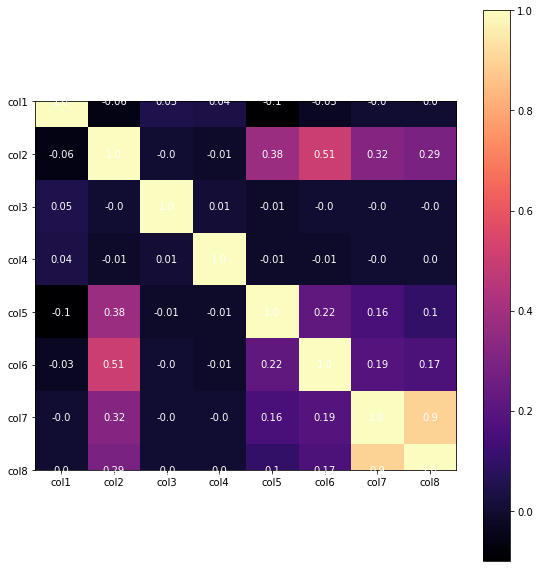

In [208]:
## train_x_past 히트맵 


corr_df1 = features.corr()
corr_df = corr_df1.apply(lambda x: round(x,2))


fig, ax=plt.subplots(figsize=(8,8))
im = ax.imshow(corr_df, cmap='magma')

# Color Bar

cbar = ax.figure.colorbar(im, ax=ax)

ax.set_xticks(np.arange(len(corr_df.columns)))
ax.set_yticks(np.arange(len(corr_df.index)))

ax.set_xticklabels(corr_df.columns)
ax.set_yticklabels(corr_df.columns)

for x in range(len(corr_df.columns)):
        for y in range(len(corr_df.index)):
            ax.text(y, x, corr_df.iloc[y, x], ha='center', va='center', color='w')

fig.tight_layout()
plt.show()


### 2_3. 로지스틱 회귀분석 (X, Y)_ 실제 모형 생성_(변수 선택)

In [209]:
## 실제 적용 모형 ##
## 로지스틱 회귀분석 step01

features_raw=reg01[['cstno','target','product_id','p_rank','is_reorder_new','is_reorder','isnot_reorder','reoder합','col1','col2','col3','col4','col5','col6','col7','col8']]
labels_raw=reg01[['target']]
features_raw.head(10) 


,cstno,target,product_id,p_rank,is_reorder_new,is_reorder,isnot_reorder,reoder합,col1,col2,col3,col4,col5,col6,col7,col8
0,111432,0,31506,66,1,10,1,11,0.032258,9,1,0,0,1,7436,900
1,91989,0,49683,32,1,4,2,6,0.023810,1,0,1,1,0,12278,901
2,136302,0,26209,9,1,2,0,2,0.071429,2,1,1,0,0,21216,1354
3,128206,0,30391,19,1,3,1,4,0.055556,1,1,1,1,0,15470,1002
4,32073,0,13176,2,1,2,1,3,0.050000,3,1,0,0,0,67514,12785
5,117493,0,44359,33,1,3,0,3,0.027778,1,0,0,0,0,12071,746
6,12670,0,21137,3,1,3,0,3,0.055556,6,0,1,0,0,52917,5083
7,190777,0,24964,12,1,8,0,8,0.020833,22,0,1,0,1,19332,1326
8,17084,0,46667,52,1,4,1,5,0.050000,2,1,0,1,0,9291,768
9,164974,0,19057,16,1,7,1,8,0.035714,4,0,1,0,0,16387,1425


In [210]:
## 로지스틱 회귀분석 step01
## 회귀분석을 위한 설명변수만 features, 종속변수를 labels로 각각 분리


features=reg01[['col1','col2','col5','col6','col7','col8']]
labels=reg01[['target']]
features.head(10) 


,col1,col2,col5,col6,col7,col8
0,0.032258,9,0,1,7436,900
1,0.023810,1,1,0,12278,901
2,0.071429,2,0,0,21216,1354
3,0.055556,1,1,0,15470,1002
4,0.050000,3,0,0,67514,12785
5,0.027778,1,0,0,12071,746
6,0.055556,6,0,0,52917,5083
7,0.020833,22,0,1,19332,1326
8,0.050000,2,1,0,9291,768
9,0.035714,4,0,0,16387,1425


In [211]:
## 로지스틱 회귀분석 step01_1
## 데이터 확인 [5,859(Cstno) X 100(product_id)]

features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585900 entries, 0 to 585899
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   col1    585900 non-null  float64
 1   col2    585900 non-null  int64  
 2   col5    585900 non-null  int64  
 3   col6    585900 non-null  int64  
 4   col7    585900 non-null  int64  
 5   col8    585900 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 26.8 MB


In [212]:
## 로지스틱 회귀분석 step02
## 설명변수 정규화 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

features = scaler.fit_transform(features)



In [213]:
## 로지스틱 회귀분석 step03
## 회귀분석 ## 실제 모델 생성 

from sklearn.linear_model import LogisticRegression

labels2=labels.values.ravel()

model = LogisticRegression()
model.fit(features,labels2)

LogisticRegression()

In [214]:
## 로지스틱 회귀분석 step04
## 회귀분석_적합률 (평가)

print(model.score(features,labels2))

0.9615173237753883


In [215]:
## 로지스틱 회귀분석 step05
## 회귀분석_각 feature들의 계수(coefficients)확인

print(model.coef_)

[[-0.31376268  0.63987403  0.27472847  0.30364998  0.34644441 -0.23086342]]


In [216]:
## 로지스틱 회귀분석 step06
## 회귀분석_정답예측률_살것이라고 모형에서 예측하는 건수

pro=model.predict_proba(features)
print(model.predict(features))
model.predict(features).sum()


[0 0 0 ... 0 0 0]


9999

In [217]:
## 로지스틱 회귀분석 step07
## 회귀분석_정답예측률을 컬럼값으로 변환

dt_proba = pd.DataFrame(model.predict_proba(features))
dt_proba.head(10)

,0,1
0,0.864015,0.135985
1,0.965273,0.034727
2,0.981168,0.018832
3,0.967910,0.032090
4,0.971641,0.028359
5,0.982688,0.017312
6,0.947323,0.052677
7,0.531143,0.468857
8,0.968770,0.031230
9,0.976102,0.023898


In [218]:
## 로지스틱 회귀분석 step08
## 기존의 회귀분석 준비 테이블하고 결합

##train_features3 = train_features2.reset_index(drop=True)
df_model_01= pd.concat([dt_proba,features_raw],axis=1,)
df_model_01.head(10)

df_model_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585900 entries, 0 to 585899
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   0               585900 non-null  float64
 1   1               585900 non-null  float64
 2   cstno           585900 non-null  object 
 3   target          585900 non-null  int64  
 4   product_id      585900 non-null  object 
 5   p_rank          585900 non-null  int64  
 6   is_reorder_new  585900 non-null  int64  
 7   is_reorder      585900 non-null  int64  
 8   isnot_reorder   585900 non-null  int64  
 9   reoder합         585900 non-null  int64  
 10  col1            585900 non-null  float64
 11  col2            585900 non-null  int64  
 12  col3            585900 non-null  int64  
 13  col4            585900 non-null  int64  
 14  col5            585900 non-null  int64  
 15  col6            585900 non-null  int64  
 16  col7            585900 non-null  int64  
 17  col8      

In [219]:
## 로지스틱 회귀분석 step09_1
## is_reordered 1인 경우는 기존 구매했던 상품에서 회귀분석 예측 모델값을 제시

df_model_01['rank_by_max'] = df_model_01.groupby('cstno')[1].rank(method='first',ascending=False)
##

df_model_01['rank'] = df_model_01.groupby('cstno')[1].rank(method='first',ascending=False)


df_model_02_1 = df_model_01[df_model_01['rank_by_max']<=df_model_01['is_reorder']]

df_model_03_1 = df_model_02_1[ (df_model_02_1['is_reorder']>=df_model_02_1['rank_by_max']) & (df_model_02_1['is_reorder_new']!=0) ]


df_model_03_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22979 entries, 0 to 170196
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   0               22979 non-null  float64
 1   1               22979 non-null  float64
 2   cstno           22979 non-null  object 
 3   target          22979 non-null  int64  
 4   product_id      22979 non-null  object 
 5   p_rank          22979 non-null  int64  
 6   is_reorder_new  22979 non-null  int64  
 7   is_reorder      22979 non-null  int64  
 8   isnot_reorder   22979 non-null  int64  
 9   reoder합         22979 non-null  int64  
 10  col1            22979 non-null  float64
 11  col2            22979 non-null  int64  
 12  col3            22979 non-null  int64  
 13  col4            22979 non-null  int64  
 14  col5            22979 non-null  int64  
 15  col6            22979 non-null  int64  
 16  col7            22979 non-null  int64  
 17  col8            22979 non-null

In [220]:
## 로지스틱 회귀분석 step09_1
## is_reordered 1인 경우는 기존 구매했던 상품에서 회귀분석 예측 모델값을 제시


df_model_00_1 = df_model_01[(df_model_01['is_reorder_new']!=0) ]
df_model_00_1=pd.DataFrame(df_model_00_1)

df_model_00_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170198 entries, 0 to 170197
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   0               170198 non-null  float64
 1   1               170198 non-null  float64
 2   cstno           170198 non-null  object 
 3   target          170198 non-null  int64  
 4   product_id      170198 non-null  object 
 5   p_rank          170198 non-null  int64  
 6   is_reorder_new  170198 non-null  int64  
 7   is_reorder      170198 non-null  int64  
 8   isnot_reorder   170198 non-null  int64  
 9   reoder합         170198 non-null  int64  
 10  col1            170198 non-null  float64
 11  col2            170198 non-null  int64  
 12  col3            170198 non-null  int64  
 13  col4            170198 non-null  int64  
 14  col5            170198 non-null  int64  
 15  col6            170198 non-null  int64  
 16  col7            170198 non-null  int64  
 17  col8      

In [221]:
## 로지스틱 회귀분석 step09_1
## is_reordered 1인 경우는 기존 구매했던 상품에서 회귀분석 예측 모델값을 제시

df_model_00_1['rank_by_max'] = df_model_00_1.groupby('cstno')[1].rank(method='first',ascending=False)
##

df_model_00_1['rank'] = df_model_00_1.groupby('cstno')[1].rank(method='first',ascending=False)


df_model_02_1 = df_model_00_1[df_model_00_1['rank_by_max']<=df_model_00_1['is_reorder']]

df_model_03_1 = df_model_02_1[ (df_model_02_1['is_reorder']>=df_model_02_1['rank_by_max']) ]


df_model_03_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22987 entries, 0 to 170196
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   0               22987 non-null  float64
 1   1               22987 non-null  float64
 2   cstno           22987 non-null  object 
 3   target          22987 non-null  int64  
 4   product_id      22987 non-null  object 
 5   p_rank          22987 non-null  int64  
 6   is_reorder_new  22987 non-null  int64  
 7   is_reorder      22987 non-null  int64  
 8   isnot_reorder   22987 non-null  int64  
 9   reoder합         22987 non-null  int64  
 10  col1            22987 non-null  float64
 11  col2            22987 non-null  int64  
 12  col3            22987 non-null  int64  
 13  col4            22987 non-null  int64  
 14  col5            22987 non-null  int64  
 15  col6            22987 non-null  int64  
 16  col7            22987 non-null  int64  
 17  col8            22987 non-null

In [222]:
## 로지스틱 회귀분석 step09_2
## is_reordered 0인 경우 p_rank로 상품추천 _ 모든 고객들에게 보편적 구매율 높은 상품 제시

df_model_01_2 = df_model_01[(df_model_01['is_reorder_new']==0)]

df_model_02_2 = pd.DataFrame(df_model_01_2)

df_model_02_2['rank']=df_model_02_2.groupby('cstno')['p_rank'].rank(method='first',ascending=True)

df_model_03_2 = df_model_02_2[ (df_model_02_2['isnot_reorder']>=df_model_02_2['rank']) & (df_model_02_2['is_reorder_new']==0) ]

df_model_03_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1437 entries, 170517 to 585856
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   0               1437 non-null   float64
 1   1               1437 non-null   float64
 2   cstno           1437 non-null   object 
 3   target          1437 non-null   int64  
 4   product_id      1437 non-null   object 
 5   p_rank          1437 non-null   int64  
 6   is_reorder_new  1437 non-null   int64  
 7   is_reorder      1437 non-null   int64  
 8   isnot_reorder   1437 non-null   int64  
 9   reoder합         1437 non-null   int64  
 10  col1            1437 non-null   float64
 11  col2            1437 non-null   int64  
 12  col3            1437 non-null   int64  
 13  col4            1437 non-null   int64  
 14  col5            1437 non-null   int64  
 15  col6            1437 non-null   int64  
 16  col7            1437 non-null   int64  
 17  col8            1437 non-n

In [223]:
## 로지스틱 회귀분석 step10_1
## is_reordered 1,0인 경우를 다시 합쳐서 전체 결과값 데이터셋으로 생성

df_model_03 = pd.concat([df_model_03_1,df_model_03_2])

df_model_03.head(10)

,0,1,cstno,target,product_id,p_rank,is_reorder_new,is_reorder,isnot_reorder,reoder합,col1,col2,col3,col4,col5,col6,col7,col8,rank_by_max,rank
0,0.864015,0.135985,111432,0,31506,66,1,10,1,11,0.032258,9,1,0,0,1,7436,900,9.0,9.0
7,0.531143,0.468857,190777,0,24964,12,1,8,0,8,0.020833,22,0,1,0,1,19332,1326,4.0,4.0
15,0.659577,0.340423,198502,1,43352,77,1,6,0,6,0.035714,14,0,1,1,1,6358,751,4.0,4.0
17,0.302133,0.697867,172768,0,21709,87,1,3,0,3,0.071429,45,1,1,1,0,5487,486,3.0,3.0
19,0.756287,0.243713,109757,0,27344,72,1,5,0,5,0.034483,9,0,1,1,1,6805,474,3.0,3.0
25,0.040949,0.959051,42830,0,47209,4,1,1,0,1,0.058824,45,1,1,1,1,42604,4350,1.0,1.0
38,0.645029,0.354971,175242,1,41950,40,1,3,0,3,0.035714,20,0,1,0,1,10981,706,2.0,2.0
44,0.509573,0.490427,186710,0,33731,56,1,3,0,3,0.052632,20,1,0,1,1,8647,561,1.0,1.0
67,0.399666,0.600334,5776,1,24852,1,1,2,0,2,0.027027,21,0,1,1,1,74686,17658,1.0,1.0
70,0.253150,0.746850,77778,1,4210,91,1,6,0,6,0.047619,39,0,1,0,1,5149,1264,1.0,1.0


In [224]:
## 로지스틱 회귀분석 step10_2
df_model_03.info()
##24,424

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24424 entries, 0 to 585856
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   0               24424 non-null  float64
 1   1               24424 non-null  float64
 2   cstno           24424 non-null  object 
 3   target          24424 non-null  int64  
 4   product_id      24424 non-null  object 
 5   p_rank          24424 non-null  int64  
 6   is_reorder_new  24424 non-null  int64  
 7   is_reorder      24424 non-null  int64  
 8   isnot_reorder   24424 non-null  int64  
 9   reoder합         24424 non-null  int64  
 10  col1            24424 non-null  float64
 11  col2            24424 non-null  int64  
 12  col3            24424 non-null  int64  
 13  col4            24424 non-null  int64  
 14  col5            24424 non-null  int64  
 15  col6            24424 non-null  int64  
 16  col7            24424 non-null  int64  
 17  col8            24424 non-null

In [225]:
## 로지스틱 회귀분석 step11_1
## target 정답 건수 체크

df_model_03.target.sum()


11976

In [226]:
## 로지스틱 회귀분석 step11_건별 검증
## 정답비교를 위한 current, train_y 조인
## 정답비교시 조인키로 사용하기 위한 train_x_current 내의 is_reorder_new, rank 변수추기 


df_current = f""" SELECT replace(case when order_interval="" then "0.0" else order_interval end,".0","") as order_interval_new
                         , is_reordered AS is_reorder_new
                         , *
                 FROM train_x_current 
            """

df_current = get_df(df_current, schema)

df_current['order_interval_new'] = df_current['order_interval_new'].astype(float)
df_current['order_number'] = df_current['order_number'].astype(float)
df_current['week_day'] = df_current['week_day'].astype(float)
df_current['order_hour'] = df_current['order_hour'].astype(float)
df_current['add_order'] = df_current['add_order'].astype(float)
df_current['is_reordered'] = df_current['is_reordered'].astype(float)
df_current['is_reorder_new'] = df_current['is_reorder_new'].astype(float)

df_y_f = pd.DataFrame(df_current.join(df_y))

df_y_f['rank']=df_y_f.groupby(['cstno','is_reorder_new'])['add_order'].rank(method='first',ascending=True)

df_y_f.head()


,order_interval_new,is_reorder_new,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,rank
0,3.0,1.0,806422,41116,47.0,5.0,18.0,3.0,4.0,1.0,21709,2.0
1,7.0,1.0,2146033,127113,45.0,1.0,10.0,7.0,24.0,1.0,21709,6.0
2,26.0,1.0,3055498,140168,45.0,5.0,10.0,26.0,11.0,1.0,21709,2.0
3,8.0,1.0,3267527,60604,52.0,0.0,16.0,8.0,2.0,1.0,21709,1.0
4,5.0,0.0,3125992,136554,46.0,4.0,9.0,5.0,2.0,0.0,21709,1.0


In [227]:
## 실제 정답과 모형을 통해 제시한 상품 정답값을 비교하기 위해 join

df_final = pd.merge(df_y_f,df_model_03, on = ['cstno','is_reorder_new','rank'])
df_final.head(20)

,order_interval_new,is_reorder_new,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,...,reoder합,col1,col2,col3,col4,col5,col6,col7,col8,rank_by_max
0,3.0,1.0,806422,41116,47.0,5.0,18.0,3.0,4.0,1.0,...,5,0.043478,18,0,1,1,0,74686,17658,2.0
1,7.0,1.0,2146033,127113,45.0,1.0,10.0,7.0,24.0,1.0,...,6,0.071429,5,1,1,1,0,21012,1577,6.0
2,26.0,1.0,3055498,140168,45.0,5.0,10.0,26.0,11.0,1.0,...,4,0.027778,8,0,1,0,1,8375,446,2.0
3,8.0,1.0,3267527,60604,52.0,0.0,16.0,8.0,2.0,1.0,...,7,0.043478,30,0,1,0,1,13505,1120,1.0
4,5.0,0.0,3125992,136554,46.0,4.0,9.0,5.0,2.0,0.0,...,7,0.027778,0,1,1,0,0,25046,2617,34.0
5,13.0,0.0,2883377,30098,45.0,0.0,15.0,13.0,19.0,0.0,...,4,0.024390,0,0,1,0,0,67514,12785,17.0
6,7.0,1.0,879062,138549,50.0,5.0,16.0,7.0,4.0,1.0,...,9,0.043478,1,0,1,0,1,52917,5083,3.0
7,5.0,1.0,3234080,42711,100.0,1.0,9.0,5.0,11.0,1.0,...,2,0.090909,10,1,1,0,1,5487,486,2.0
8,6.0,1.0,2026101,114720,44.0,0.0,20.0,6.0,2.0,1.0,...,5,0.021739,11,0,0,1,1,12531,1753,1.0
9,21.0,1.0,1732236,182942,49.0,0.0,15.0,21.0,2.0,1.0,...,4,0.028571,10,0,1,0,1,52917,5083,1.0


In [228]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24424 entries, 0 to 24423
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_interval_new  24424 non-null  float64
 1   is_reorder_new      24424 non-null  float64
 2   order_id            24424 non-null  object 
 3   cstno               24424 non-null  object 
 4   order_number        24424 non-null  float64
 5   week_day            24424 non-null  float64
 6   order_hour          24424 non-null  float64
 7   order_interval      24424 non-null  object 
 8   add_order           24424 non-null  float64
 9   is_reordered        24424 non-null  float64
 10  product_id_x        24424 non-null  object 
 11  rank                24424 non-null  float64
 12  0                   24424 non-null  float64
 13  1                   24424 non-null  float64
 14  target              24424 non-null  int64  
 15  product_id_y        24424 non-null  object 
 16  p_ra

In [229]:
## 건별 체크

df_final[['cstno','product_id_x','product_id_y']]

,cstno,product_id_x,product_id_y
0,41116,21709,24852
1,127113,21709,47626
2,140168,21709,21938
3,60604,21709,45066
4,136554,21709,47766
...,...,...,...
24419,174046,24852,39928
24420,6710,24852,47209
24421,150840,24852,31717
24422,99707,24852,9387


## Chapter 5. 생성된 모형에 Test 데이터 대입하여 솔루션(정답값) 도출

In [230]:
## 로지스틱 회귀분석 적용(test_set) step01

## 고객별 모든 상품에 대한 구매확률 계산을 위해 [고객별 x 100] Row 테이블 생성

## 데이터셋(독립변수)생성 2
## current. past 정보 활용하여 생성된 고객테이블 바탕으로 
## 고객별 x 상품별 데이터셋(독립변수) 생성 (고객수 x 100)
 

##  target = 로지스틱 회귀분석 목적변수 *
##         = current에 대응하는 train_y [해당상품 구매 여부]* 

##  pnt= 고객단 구매상품 갯수 
##  p_rank = past [상품별 구매빈도 순위]
## 고객당구매건 = past [고객단 전체 구매 건수]
## 고객당상품구매건 = past [고객단 해당상품 구매 건수]
## 구매율 = [고객당상품구매건/고객당구매건]
## p_avg = past [고객당 해당상품 평균 구매주기(order_interval)] 
## is_reorder_new = 해당 상품 재구매여부
## is_reorder = current[재구매 건수]
## isnot_reorder = current[비재구매 건수]
## reoder합 = current[전체주문건수(is_reorder+isnot_reorder)]


##  col1 = past [1/고객단 구매상품 갯수 pnt] 
##  col2 = past [고객별 상품 구매수]
##  col3 = current [ week_day 범주화 금, 토, 일 = 0 / 월~목 = 1]
##  col4 = current [order_hour 9~6 then 1 else 0]
##  col5 = past [상품의 평균 order_interval 보다 고객단 해당상품 평균 order_interval 가 크면 1 else 0]
##  col6 = past [고객별 past 에서 가장 마지막 order_id 에 해당상품이 구매시 1 else 0 ]
##  col7 = past [전체 고객에 대한 상품별 구매수] 
##  col8 = past [상품별 add_order가 1인 횟수]


## [항목별 수정내용]
## col1 : 고객단 구매상품 갯수  ->  1/고객단 구매상품 갯수 
## col2 = 고객별 상품 구매율 (해당상품구매건수/전체구매건수)  ->  고객별 상품 구매수
## col3 = [current 토, 일 = 0 / 월~금 = 1]  ->  [current 금, 토, 일 = 0 / 월~금 = 1]



reg01 = f"""   with product as 
                    (  select product_id
                            , count(*) as 총상품구매
                            , count(*)/count(distinct cstno) as 인당구매건
                            , count(distinct cstno) as 상품구매인
                            , sum(cast(week_day as int))/ count(*) as 평균요일
                            , sum(case when week_day in ('0','1') then 0 else 1 end)/ count(*) as 평일여부
                            , sum(cast(order_hour as int))/ count(*) as 평균구매시각
                            , sum(case when cast(order_hour as int) between 9 and 18 then 1 else 0 end)/ count(*) as 일과시간여부
                            , sum(cast(add_order as int))/ count(*) as 평균add_order
                            , rank() over (order by  count(*) desc) as p_rank
                            , sum(case when add_order	='1' then 1 else 0 end ) as col8
                       from test_x_past 
                       group by product_id    
                       
                     )
           , base1 as ( select p.cstno , product_id 
                            from (SELECT *, ROW_NUMBER() OVER ( ORDER BY ( NULL) ) AS ROWID
                                  FROM test_x_current) p
                            left join ( SELECT product_id , ROW_NUMBER() OVER ( ORDER BY ( NULL) ) AS ROWID2 
                                        FROM train_y ) p2
                             on p.ROWID=p2.ROWID2  
                          group by p.cstno , product_id
                           )
                           
                select r.cstno, r.product_id
                      , case when r.product_id=r1.product_id then 1 else 0 end as target
                      , pnt       
                      , 고객당구매건
                      , case when 고객당상품구매건 is null then 0 else 고객당상품구매건 end as 고객당상품구매건
                      , case when 고객당상품구매건 is null then 0 else 고객당상품구매건 / 고객당구매건 *100 end AS 구매율
                    
                      , p_avg
                      , case when 고객당상품구매건 is null then 0 else 1 end as is_reorder_new
                      , is_reorder, isnot_reorder
                      , p_rank
                      , is_reorder+isnot_reorder as reoder합
                      
                        , 1/pnt as col1
                      --, case when 고객당상품구매건 is null then 0 else 고객당상품구매건 / 고객당구매건 *100 end as col2
                      , case when 고객당상품구매건 is null then 0 else 고객당상품구매건 end as col2
                      , case when week_day in ('0','6','5') then 0 else 1 end as col3
                      , case when cast(order_hour as int)  between 9 and 18 then 1 else 0 end as col4
                      , case when cast(replace(order_interval,".0","") as int)<=nvl(p_avg,0) then 1 else 0 end as col5 
                      , nvl(최근구매여부,0) as col6
                      , 총상품구매 as col7
                      , col8
                    from ( SELECT t.cstno , t1.product_id  , week_day , order_hour , order_interval 
                            FROM test_x_current t
                            left join products_info t1
                            on 0=0
                            group by t.cstno , t1.product_id , week_day , order_hour , order_interval 
                            ) r
                left join base1 r1
                on r.cstno=r1.cstno  
                and r.product_id=r1.product_id   

                left join product r2
                on  r.product_id=r2.product_id   
                
                left join (select cstno, count(*) as 고객당구매건 , count(distinct product_id) as pnt
                           from test_x_past 
                           group by cstno) r3
                 on r.cstno=r3.cstno
               
                left join (select  y.cstno , y.product_id, count(*) as 고객당상품구매건
                                , sum(CASE WHEN order_interval is not null then cast(replace(order_interval,".0","")  as int) else 0 end) 
                                /count(case when order_interval is not null then 1 else 0 end ) as p_avg
                                , max(case when y2.order_id is not null then 1 else 0 end) as 최근구매여부          
                               from test_x_past y
                               left join ( select  cstno, order_id, order_number
                                                                , rank() over (partition by cstno
                                                                                order by cast(order_number as int) desc
                                                                                ) 
                                                                  as v_rank
                                         from test_x_past               
                                         group by cstno, order_id, order_number
                                         order by v_rank
                                        ) y2
                                    on y.order_id=y2.order_id       
                                    and y2.v_rank =1                
                                group by y.cstno, y.product_id
                
                ) r4
                 on r.cstno=r4.cstno    
                 and r.product_id=r4.product_id 
              
              left join (SELECT  cstno, sum(cast(is_reordered as int)) as is_reorder
                              , count(*)- sum(cast(is_reordered as int)) as isnot_reorder
                        FROM test_x_current t
                        group by cstno
                        ) r5
                 on r.cstno=r5.cstno     
           --   where r.product_id='24852'

            """
reg01  = get_df(reg01, schema)

reg01.head(10)       

##

,cstno,product_id,target,pnt,고객당구매건,고객당상품구매건,구매율,p_avg,is_reorder_new,is_reorder,...,p_rank,reoder합,col1,col2,col3,col4,col5,col6,col7,col8
0,29803,27845,0,29,77,1,1.298701,12.000000,1,1,...,7,2,0.034483,1,1,1,1,0,10837,2331
1,135465,17794,0,30,194,2,1.030928,17.000000,1,1,...,30,1,0.033333,2,0,1,0,0,5295,409
2,124148,22035,0,7,77,7,9.090909,8.285714,1,1,...,38,1,0.142857,7,1,1,0,0,4870,415
3,48247,4210,0,11,78,1,1.282051,8.000000,1,2,...,96,2,0.090909,1,0,0,1,0,2253,512
4,113054,5450,0,36,249,9,3.614458,10.888889,1,6,...,65,7,0.027778,9,0,0,0,1,3301,285
5,111000,17794,0,21,98,3,3.061224,5.000000,1,4,...,30,4,0.047619,3,1,0,0,0,5295,409
6,49030,46667,0,31,106,1,0.943396,1.000000,1,1,...,55,1,0.032258,1,0,1,0,0,3896,295
7,187681,43961,0,39,203,1,0.492611,NaN,1,6,...,49,6,0.025641,1,0,1,0,0,4107,224
8,28497,41787,1,32,155,1,0.645161,2.000000,1,6,...,76,6,0.031250,1,0,0,0,0,2906,214
9,72511,45007,0,34,131,1,0.763359,9.000000,1,7,...,14,8,0.029412,1,0,1,0,0,8035,417


In [231]:
## 실제 적용 모형 ##
## 로지스틱 회귀분석(test_set)  step02


test_features_pd=reg01[['cstno','target','product_id','p_rank','is_reorder_new','is_reorder','isnot_reorder','reoder합','col1','col2','col3','col4','col5','col6','col7','col8']]
test_features=reg01[['col1','col2','col5','col6','col7','col8']]

In [232]:
## 로지스틱 회귀분석(test_set)  step03
## 데이터 정규화

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

test_features = scaler.fit_transform(test_features)
##test_features = scaler.transform(test_features)


In [233]:
## 로지스틱 회귀분석(test_set)  step04
## 데이터 모델적용

print(model.predict(test_features))

[0 0 0 ... 0 0 0]


In [234]:
## 로지스틱 회귀분석(test_set)  step05
## 회귀분석_정답_살것이라고 모형에서 예측하는 건수

model.predict(test_features).sum()

7683

In [235]:
## 로지스틱 회귀분석(test_set)  step06
## 회귀분석_정답예측률을 컬럼값으로 변환

dt_test = pd.DataFrame(model.predict_proba(test_features))
dt_test.head(10)

,0,1
0,0.962513,0.037487
1,0.977983,0.022017
2,0.968504,0.031496
3,0.974494,0.025506
4,0.761111,0.238889
5,0.975522,0.024478
6,0.982444,0.017556
7,0.981443,0.018557
8,0.983249,0.016751
9,0.976977,0.023023


In [236]:
## 로지스틱 회귀분석 step07
## 기존의 회귀분석 준비 테이블하고 결합

final_y_01 = pd.concat([dt_test,test_features_pd],axis=1)
final_y_01.head(10)

,0,1,cstno,target,product_id,p_rank,is_reorder_new,is_reorder,isnot_reorder,reoder합,col1,col2,col3,col4,col5,col6,col7,col8
0,0.962513,0.037487,29803,0,27845,7,1,1,1,2,0.034483,1,1,1,1,0,10837,2331
1,0.977983,0.022017,135465,0,17794,30,1,1,0,1,0.033333,2,0,1,0,0,5295,409
2,0.968504,0.031496,124148,0,22035,38,1,1,0,1,0.142857,7,1,1,0,0,4870,415
3,0.974494,0.025506,48247,0,4210,96,1,2,0,2,0.090909,1,0,0,1,0,2253,512
4,0.761111,0.238889,113054,0,5450,65,1,6,1,7,0.027778,9,0,0,0,1,3301,285
5,0.975522,0.024478,111000,0,17794,30,1,4,0,4,0.047619,3,1,0,0,0,5295,409
6,0.982444,0.017556,49030,0,46667,55,1,1,0,1,0.032258,1,0,1,0,0,3896,295
7,0.981443,0.018557,187681,0,43961,49,1,6,0,6,0.025641,1,0,1,0,0,4107,224
8,0.983249,0.016751,28497,1,41787,76,1,6,0,6,0.031250,1,0,0,0,0,2906,214
9,0.976977,0.023023,72511,0,45007,14,1,7,1,8,0.029412,1,0,1,0,0,8035,417


In [237]:
## 로지스틱 회귀분석 step08
## is_reorder 건수 체크 

final_y_01.is_reorder.sum()/100

14657.0

In [238]:
## 로지스틱 회귀분석 step09_1
## is_reordered 1인 경우는 기존 구매했던 상품에서 회귀분석 예측 모델값을 제시

final_y_02 = final_y_01[(final_y_01['is_reorder_new']!=0) ]
final_y_02=pd.DataFrame(final_y_02)

final_y_02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98203 entries, 0 to 98202
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   0               98203 non-null  float64
 1   1               98203 non-null  float64
 2   cstno           98203 non-null  object 
 3   target          98203 non-null  int64  
 4   product_id      98203 non-null  object 
 5   p_rank          98203 non-null  int64  
 6   is_reorder_new  98203 non-null  int64  
 7   is_reorder      98203 non-null  int64  
 8   isnot_reorder   98203 non-null  int64  
 9   reoder합         98203 non-null  int64  
 10  col1            98203 non-null  float64
 11  col2            98203 non-null  int64  
 12  col3            98203 non-null  int64  
 13  col4            98203 non-null  int64  
 14  col5            98203 non-null  int64  
 15  col6            98203 non-null  int64  
 16  col7            98203 non-null  int64  
 17  col8            98203 non-null 

In [239]:
## 로지스틱 회귀분석 step09_2
## is_reordered 1인 경우는 기존 구매했던 상품에서 회귀분석 예측 모델값을 제시

final_y_02['rank_by_max'] = final_y_02.groupby('cstno')[1].rank(method='first',ascending=False)
##

final_y_02['rank'] = final_y_02.groupby('cstno')[1].rank(method='first',ascending=False)


final_y_02_1 = final_y_02[final_y_02['rank_by_max']<=final_y_02['is_reorder']]

final_y_03_1 = final_y_02_1[ (final_y_02_1['is_reorder']>=final_y_02_1['rank_by_max']) ]


final_y_03_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14657 entries, 12 to 98200
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   0               14657 non-null  float64
 1   1               14657 non-null  float64
 2   cstno           14657 non-null  object 
 3   target          14657 non-null  int64  
 4   product_id      14657 non-null  object 
 5   p_rank          14657 non-null  int64  
 6   is_reorder_new  14657 non-null  int64  
 7   is_reorder      14657 non-null  int64  
 8   isnot_reorder   14657 non-null  int64  
 9   reoder합         14657 non-null  int64  
 10  col1            14657 non-null  float64
 11  col2            14657 non-null  int64  
 12  col3            14657 non-null  int64  
 13  col4            14657 non-null  int64  
 14  col5            14657 non-null  int64  
 15  col6            14657 non-null  int64  
 16  col7            14657 non-null  int64  
 17  col8            14657 non-null

In [240]:
## 로지스틱 회귀분석 step09_3
## is_reordered 0인 경우 p_rank로 상품추천 _ 모든 고객들에게 보편적 구매율 높은 상품 제시

final_y_01_2 = final_y_01[(final_y_01['is_reorder_new']==0)]

final_y_02_2 = pd.DataFrame(final_y_01_2)

final_y_02_2['rank']=final_y_02_2.groupby('cstno')['p_rank'].rank(method='first',ascending=True)

final_y_03_2 = final_y_02_2[ (final_y_02_2['isnot_reorder']>=final_y_02_2['rank']) & (final_y_02_2['is_reorder_new']==0) ]

final_y_03_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1469 entries, 98318 to 413631
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   0               1469 non-null   float64
 1   1               1469 non-null   float64
 2   cstno           1469 non-null   object 
 3   target          1469 non-null   int64  
 4   product_id      1469 non-null   object 
 5   p_rank          1469 non-null   int64  
 6   is_reorder_new  1469 non-null   int64  
 7   is_reorder      1469 non-null   int64  
 8   isnot_reorder   1469 non-null   int64  
 9   reoder합         1469 non-null   int64  
 10  col1            1469 non-null   float64
 11  col2            1469 non-null   int64  
 12  col3            1469 non-null   int64  
 13  col4            1469 non-null   int64  
 14  col5            1469 non-null   int64  
 15  col6            1469 non-null   int64  
 16  col7            1469 non-null   int64  
 17  col8            1469 non-nu

In [241]:
## 로지스틱 회귀분석 step10_1
## is_reordered 1,0인 경우를 다시 합쳐서 전체 결과값 데이터셋으로 생성

final_y_03 = pd.concat([final_y_03_1,final_y_03_2])

final_y_03.head(10)

,0,1,cstno,target,product_id,p_rank,is_reorder_new,is_reorder,isnot_reorder,reoder합,col1,col2,col3,col4,col5,col6,col7,col8,rank_by_max,rank
12,0.699564,0.300436,132704,0,5876,18,1,4,1,5,0.032258,10,0,0,0,1,6464,528,2.0,2.0
17,0.621468,0.378532,161310,0,47144,89,1,6,0,6,0.034483,9,1,1,1,1,2511,392,3.0,3.0
18,0.932112,0.067888,98682,0,33198,74,1,5,0,5,0.090909,2,1,1,0,1,2930,554,5.0,5.0
19,0.893238,0.106762,84894,0,15290,88,1,5,1,6,0.028571,13,1,1,0,0,2604,152,5.0,5.0
24,0.668417,0.331583,38837,0,3957,69,1,5,1,6,0.055556,18,0,1,1,0,3245,584,2.0,2.0
34,0.655434,0.344566,169746,0,10749,45,1,10,1,11,0.029412,7,1,1,1,1,4300,261,3.0,3.0
41,0.056296,0.943704,101933,0,13176,2,1,4,0,4,0.055556,26,0,1,1,1,29086,5751,1.0,1.0
45,0.319242,0.680758,7310,0,21938,51,1,8,0,8,0.052632,21,1,1,0,1,4000,223,3.0,3.0
50,0.637943,0.362057,137506,0,25890,56,1,7,0,7,0.035714,8,0,1,1,1,3887,400,5.0,5.0
51,0.837321,0.162679,65621,0,33731,64,1,7,0,7,0.071429,12,0,1,1,0,3364,215,6.0,6.0


In [242]:
## 로지스틱 회귀분석 step11_01
## 정답제출을 위한 test_current 불러오기
## final_y_03을 current와 조인하기 위한 조인키로 train_x_current 내의 is_reorder_new 변수추기 


df_test_current = f""" SELECT   ROW_NUMBER() OVER ( ORDER BY ( NULL) ) AS ROWID1  
                         , is_reordered AS is_reorder_new 
                         , *
                 FROM test_x_current 
            """

df_test_current = get_df(df_test_current, schema)

df_test_past = f""" SELECT *
                 FROM test_x_past 
            """

df_test_past = get_df(df_test_past, schema)




df_test_current['order_number'] = df_test_current['order_number'].astype(float)
df_test_current['week_day'] = df_test_current['week_day'].astype(float)
df_test_current['order_hour'] = df_test_current['order_hour'].astype(float)
df_test_current['add_order'] = df_test_current['add_order'].astype(float)
df_test_current['is_reordered'] = df_test_current['is_reordered'].astype(float)
df_test_current['is_reorder_new'] = df_test_current['is_reorder_new'].astype(float)

df_test_current[['cstno']]

,cstno
0,37987
1,169022
2,200090
3,149416
4,113836
...,...
16121,57077
16122,83592
16123,157740
16124,92043


In [243]:
final_y_03.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16126 entries, 12 to 413631
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   0               16126 non-null  float64
 1   1               16126 non-null  float64
 2   cstno           16126 non-null  object 
 3   target          16126 non-null  int64  
 4   product_id      16126 non-null  object 
 5   p_rank          16126 non-null  int64  
 6   is_reorder_new  16126 non-null  int64  
 7   is_reorder      16126 non-null  int64  
 8   isnot_reorder   16126 non-null  int64  
 9   reoder합         16126 non-null  int64  
 10  col1            16126 non-null  float64
 11  col2            16126 non-null  int64  
 12  col3            16126 non-null  int64  
 13  col4            16126 non-null  int64  
 14  col5            16126 non-null  int64  
 15  col6            16126 non-null  int64  
 16  col7            16126 non-null  int64  
 17  col8            16126 non-nul

In [244]:
## 로지스틱 회귀분석 step11_02
## final_y_03을 current와 조인하기 위한 조인키로 사용하기 위해 rank 변수추기 

df_test_current['rank']=df_test_current.groupby(['cstno','is_reorder_new'])['add_order'].rank(method='first',ascending=True)

df_test_current.head(10)

,rowid1,is_reorder_new,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,rank
0,1,1.0,3384204,37987,38.0,5.0,16.0,13.0,9.0,1.0,4.0
1,2,1.0,2578612,169022,38.0,6.0,10.0,7.0,4.0,1.0,3.0
2,3,1.0,188887,200090,45.0,5.0,16.0,30.0,5.0,1.0,3.0
3,4,1.0,646772,149416,39.0,1.0,13.0,13.0,15.0,1.0,8.0
4,5,1.0,300214,113836,42.0,3.0,10.0,17.0,1.0,1.0,1.0
5,6,0.0,3038310,82311,41.0,6.0,17.0,2.0,4.0,0.0,1.0
6,7,1.0,512912,65435,42.0,1.0,14.0,6.0,3.0,1.0,1.0
7,8,1.0,2626840,185866,37.0,3.0,11.0,2.0,12.0,1.0,4.0
8,9,1.0,1917041,2866,38.0,4.0,14.0,20.0,3.0,1.0,3.0
9,10,1.0,2000195,36228,38.0,5.0,7.0,11.0,2.0,1.0,1.0


In [245]:
## 로지스틱 회귀분석 step12
## final_y_03을 current와 조인

test_final = pd.merge(df_test_current,final_y_03, on = ['cstno','is_reorder_new','rank'])
test_final.head(20)
test_y = test_final[['product_id']]

test_y = pd.DataFrame(test_y)

In [246]:
## 로지스틱 회귀분석 step13_01
## 정답제출 전 샘플 데이터 체크 cstno ('169022')

test_final2 = test_final[(test_final['cstno']=='169022' )]

test_final2.head(10)

,rowid1,is_reorder_new,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,...,reoder합,col1,col2,col3,col4,col5,col6,col7,col8,rank_by_max
1,2,1.0,2578612,169022,38.0,6.0,10.0,7.0,4.0,1.0,...,9,0.034483,22,0,1,1,1,4497,600,3.0
1654,1655,1.0,2578612,169022,38.0,6.0,10.0,7.0,3.0,1.0,...,9,0.034483,31,0,1,0,1,3426,482,2.0
3098,3099,1.0,2578612,169022,38.0,6.0,10.0,7.0,5.0,1.0,...,9,0.034483,19,0,1,0,1,16237,1607,4.0
4192,4193,0.0,2578612,169022,38.0,6.0,10.0,7.0,22.0,0.0,...,9,0.034483,0,0,1,0,0,29086,5751,NaN
5284,5285,1.0,2578612,169022,38.0,6.0,10.0,7.0,8.0,1.0,...,9,0.034483,19,0,1,0,1,2186,225,6.0
7925,7926,1.0,2578612,169022,38.0,6.0,10.0,7.0,6.0,1.0,...,9,0.034483,28,0,1,0,0,6356,594,5.0
8184,8185,1.0,2578612,169022,38.0,6.0,10.0,7.0,23.0,1.0,...,9,0.034483,14,0,1,0,1,6174,337,8.0
8470,8471,1.0,2578612,169022,38.0,6.0,10.0,7.0,12.0,1.0,...,9,0.034483,14,0,1,0,1,8035,417,7.0
9475,9476,1.0,2578612,169022,38.0,6.0,10.0,7.0,2.0,1.0,...,9,0.034483,31,0,1,0,1,34287,8033,1.0


In [247]:
## 로지스틱 회귀분석 step13_02
## 정답제출 전 샘플 데이터 체크 cstno ('169022')

df_test_current2 = df_test_current[(df_test_current['cstno']=='169022' )]
df_test_current2.head(10)

,rowid1,is_reorder_new,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,rank
1,2,1.0,2578612,169022,38.0,6.0,10.0,7.0,4.0,1.0,3.0
1654,1655,1.0,2578612,169022,38.0,6.0,10.0,7.0,3.0,1.0,2.0
3098,3099,1.0,2578612,169022,38.0,6.0,10.0,7.0,5.0,1.0,4.0
4192,4193,0.0,2578612,169022,38.0,6.0,10.0,7.0,22.0,0.0,1.0
5284,5285,1.0,2578612,169022,38.0,6.0,10.0,7.0,8.0,1.0,6.0
7925,7926,1.0,2578612,169022,38.0,6.0,10.0,7.0,6.0,1.0,5.0
8184,8185,1.0,2578612,169022,38.0,6.0,10.0,7.0,23.0,1.0,8.0
8470,8471,1.0,2578612,169022,38.0,6.0,10.0,7.0,12.0,1.0,7.0
9475,9476,1.0,2578612,169022,38.0,6.0,10.0,7.0,2.0,1.0,1.0


In [250]:
## 로지스틱 회귀분석 step13_03
## 정답제출 전 샘플 데이터 체크 cstno ('169022')

df_test_past3 = f""" SELECT product_id
                            ,count(*)
                     FROM test_x_past 
                     WHERE cstno in ('169022')
                     GROUP by product_id
            """

df_test_past3 = get_df(df_test_past3, schema)


df_test_past3.head(10)

,product_id,expr_1
0,46979,4
1,19660,1
2,44142,1
3,40706,14
4,16759,8
5,21903,1
6,47626,1
7,21137,8
8,24852,31
9,45007,14


In [249]:
## 로지스틱 회귀분석 step14
## 정답제출

test_y.to_csv('./test_y.csv')

## Chapter 6. 결론 및 한계

<p style="font-weight:bold"> 결론 <br> 
　이번 대회를 위해 과거 구매이력과 현재 구매 정보를 활용하여 과거 구매 상품 중 현재 재구매 할 만한 상품을 제안하였음.<br>
　로지스틱 회귀분석 모형을 통해 고객별로 구매할 가능성이 가장 높은 상품들을 선택하여 제시하였음.<br>
　간단한 방법으로 고객에게 맞는 상품을 추천할 수 있는 적합한 모형으로 판단됨.</p>

<p style="font-weight:bold"> 한계 <br> 
　구매한 이력이 있는 상품 중 현재 Currnet Data의 add_order 변수를 활용하지 못한 점,<br>
　추천 상품이 단순히 과거에 어떤 상품을 얼마나 구매했는지에 너무 크게 좌우된다는 점,<br>
　구매한 이력이 없는 상품을 제시할 때, 모든 고객의 보편적 선호를 통해 상품을 제시하고<br>
　고객의 과거 구매이력 Pool 을 이용하여 연관된 상품을 제시하지 못한 점은 향후 과제로 남아 있음</p>